<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
download = False
if not os.path.isfile("./cifar-10-python.tar.gz"):
    download = True

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

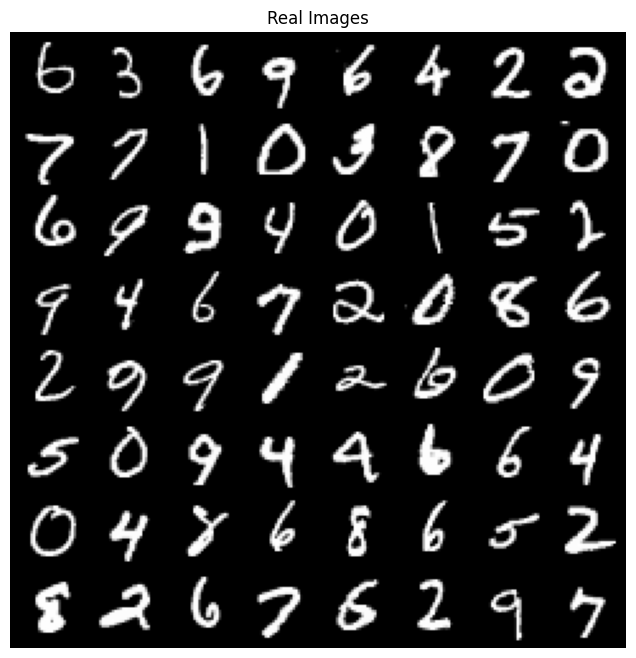

In [4]:
import matplotlib.pyplot as plt


real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

![image.png](attachment:./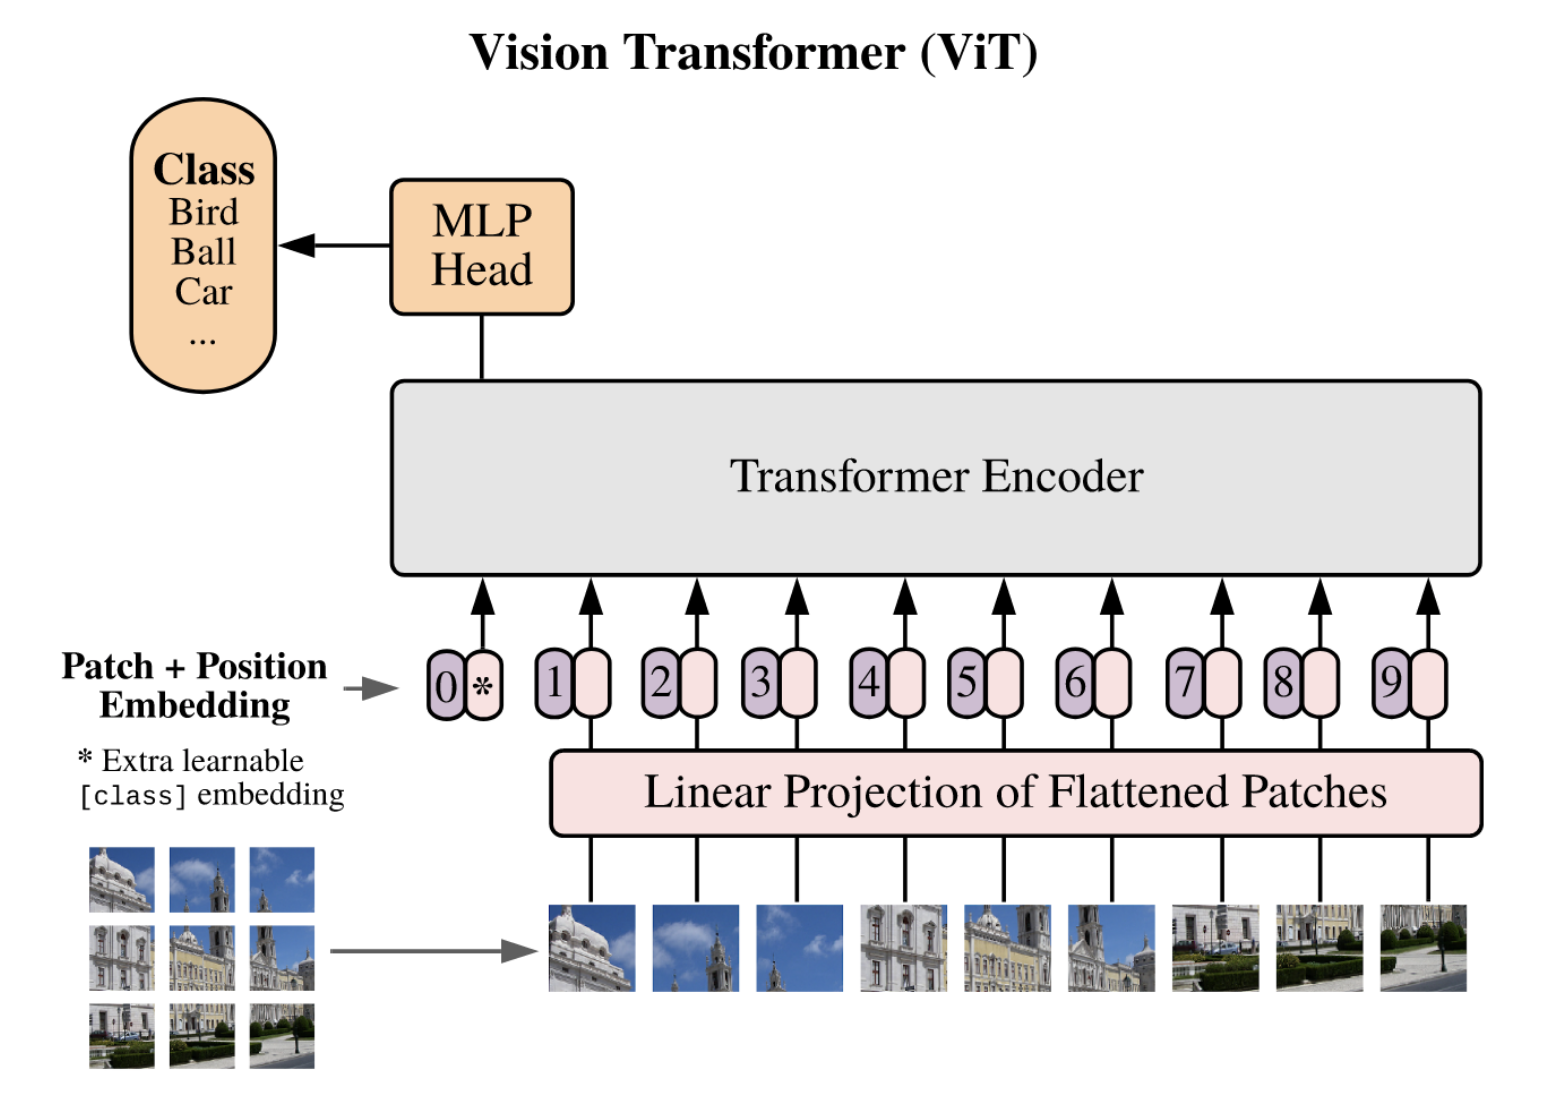)

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [5]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    """
      x.shape : (Batch, Channels, height, width)
    """
    x = self.projection(x)
    
    B, C, H, W = x.size() # Here C = embedding_dim

    # Reshape from B x C x H x W to B x N x C where N is H*W (the number of 'tokens').
    x = x.view(B, C, -1) # Flatten the H and W dimensions.
      
    # Shape is now B x C x N, we simply need to permute to get B x N x C 
    x = x.permute(0, 2, 1)

    # x.size() -> B, N, C
    return x

In [6]:
PatchEmbed(in_chan=2)(torch.randn(32, 2, 28, 28)).size()

torch.Size([32, 16, 128])

# Transformer encoder

![image.png](attachment:./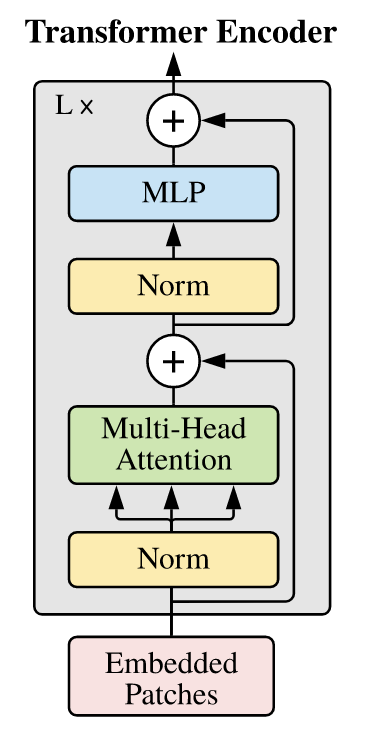)

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:

class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.seq = nn.Sequential(nn.Linear(in_features, hid_features), nn.GELU(), nn.Linear(hid_features, in_features)) 

  def forward(self, x):
    return self.seq(x)


MLP(128, 512)(torch.randn(32, 16, 128)).size()

torch.Size([32, 16, 128])

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart? What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!

**Main feature of self-attention**: Unlike convolutional layers that consider a local neighborhood around each input position, self-attention can weigh all positions across the entire sequence, providing a form of global receptive field. This is beneficial for tasks where the relevant context can be far from the current position.

**Main challenge in terms of computation/memory**:

**Equations**:
$$
\begin{align}
Q = XW_q, \, K = XW_k, \, V = XW_v \\
\text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^t}{\sqrt{d_k}}\right)V
\end{align}
$$


## Q3: Self-attention

In [8]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.scale = embed_dim**0.5
    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.final_linear = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    """
    B : batch size
    N : nombre d'embedding = nombre de patch d'image 
    C : taille d'un embedding 
    """
    B, N, C = x.shape

    # Compute the Q, K, V
    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)

    # Compute the final version using the attention V, and the final projection
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v
    return self.final_linear(x)

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

**Equations**:

$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$ where $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$


The Attention function is the same as described in the single-head attention, and $W^O$ is the final linear layer's weights.


In [9]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.W_q(x)
    k = self.W_k(x)
    v = self.W_v(x)
      
    print(q.size())

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.
    
    attention = q @ k.transpose(1, 2) / self.scale
    x = F.softmax(attention, dim=2) @ v

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    return x

  def transpose_qkv(self, X):
      """Transposition for parallel computation of multiple attention heads."""
      # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). 
      # Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
      X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
      # Shape of output X: (batch_size, num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      X = X.permute(0, 2, 1, 3)
      # Shape of output: (batch_size * num_heads, no. of queries or key-value
      # pairs, num_hiddens / num_heads)
      return X.reshape(-1, X.shape[2], X.shape[3])
  
  
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [10]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # Validate that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError("Embedding dimension must be divisible by the number of heads.")

        self.num_heads = num_heads
        head_dim = embed_dim // num_heads  # Determine the dimension size of each head
        self.scale = head_dim ** -0.5  # Scale factor for the dot product

        # These are the linear layers used for the multi-head attention
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)

        # This is the final linear layer used after the self-attention
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, C = x.shape  # Batch size, number of tokens, and embedding dimension

        # First, we pass through the linear layers
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        # Reshape Q, K, V for the attention computation
        q = q.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        k = k.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)
        v = v.view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # Shape: (B, num_heads, N, head_dim)

        # Scaled dot-product attention calculation
        ###################### On divise ou multipli par la scale attention ?
        attention_scores = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale  # Shape: (B, num_heads, N, N)
        attention = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention, v)  # Shape: (B, num_heads, N, head_dim)

        # Concatenating the multi-head attention results
        out = out.permute(0, 2, 1, 3).contiguous().view(B, N, C)  # Shape: (B, N, C)

        # Final linear layer
        out = self.projection(out)  # Shape: (B, N, C)

        return out

    
MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).size()

torch.Size([32, 16, 6])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

**Equations**:

y = MLP(LayerNorm)

In [11]:
# normalisation : use layer norm from pytorch, similar to batch normalisation but the mean & std is computed across the channel feature
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)

  def forward(self, x):
    out = self.norm(x)
    out = self.attention(out)
    x = out + x
    out = self.norm(x)
    out = self.mlp(out)
    return out + x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [12]:

class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        # Multi-head self-attention mechanism
        self.attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward neural network (MLP)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, mlp_ratio * embed_dim),  # Linear layer
            nn.GELU(),  # Activation function
            nn.Linear(mlp_ratio * embed_dim, embed_dim),  # Linear layer
        )

    def forward(self, x):
        # Apply multi-head attention followed by layer normalization
        attention_output = self.attention(x)
        x = self.norm1(x + attention_output)  # Residual connection

        # Apply feed-forward neural network followed by layer normalization
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)  # Residual connection

        return x

    
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

![](https://www.researchgate.net/publication/348947034/figure/fig2/AS:986572736446471@1612228678819/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the.png)

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

1. Explain what is a Class token and why we use it? 
2. Explain what is the positional embedding (PE) and why it is important?

For PE, you can use a sinusoidal encoding (see below), or fully learned.

1. The class token is positionned as the first token. It is represented as a learnable vector which gets updated during the forward pass. It accumulate information from different parts of the image as it gets updated through the Transformer layers. As it sum-up all the image, we use it to classify the image.
2. The PE are used to provide the spacial information to the model. Here we use sinusoidal encoding, it provide a fixed, unique and easy to generate encodding for the position. 

It look something like that :

![Heatmap of Positional embeddings for one hundred 300-dimensional samples. Samples are on the y-axis, whereas the dimensions are on the x-axis. Darker regions show higher values.](https://miro.medium.com/v2/resize:fit:640/format:webp/1*erwsFgn3I-FGzUKOIeQSAw.png)

Another approach is to learn this positional embedding. This method allows the model to learn the most useful positional representations.

This positionnal embedding is then sum to the image embedding.

### Sinusoidal PE

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10, num_heads=4, mlp_ratio=4):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.ones(1, embed_dim),requires_grad=False)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(num_patches+1, embed_dim), requires_grad=False)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(Block(embed_dim, num_heads=num_heads, mlp_ratio=num_heads))
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
            nn.Linear(embed_dim, nb_classes),
            nn.Softmax(dim=-1)
        )

  @staticmethod
  def get_positional_embeddings(sequence_length, d):
    """
    given the number of tokens and the dimensionality of each of them, 
    outputs a matrix where each coordinate (i,j) is the value to be added to token i in dimension j.
    """
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
  
  def forward(self, x):
    batch_size = x.size(0)
    x = self.patch_embed(x) ## image to patches => B, N, C

    ## concatenating class token of shape (1, embedding dim) for every example
    x = torch.cat((self.class_token.repeat(batch_size, 1, 1), x), dim=1)
    
    ## adding positional embedding
    x += self.pos_embed.repeat(batch_size, 1, 1)

    ## forward in the transformer
    x = self.blocks(x)[:, 0, :] # We take only the CLS token
    
    ## Normalize the output
    x = self.norm(x)

    output = self.head(x) ## classification output

    return output
  


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader, num_classes):
  model.eval()
  acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  loss = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)
    loss += F.cross_entropy(yhat, y)
    acc(yhat.argmax(dim=1), y)

  model.train()
  return loss.item(), acc.compute().item()

And run! Feel free to try other hyperparameters.

In [15]:
import torchmetrics
from tqdm import tqdm
def main(epochs = 10, embed_dim = 32, patch_size = 7, nb_blocks = 2, num_classes=10, num_heads=4, mlp_ratio=4, model=None, tqdm_batch=False):
  if not model:
    model = ViT(embed_dim, nb_blocks, patch_size, num_heads=num_heads, mlp_ratio=mlp_ratio).cuda()
  if tqdm_batch:
    train_loader_main = tqdm(train_loader)
  else:
    train_loader_main = train_loader
  opt = torch.optim.Adam(model.parameters())
  acc_train = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes).cuda()
  acc_train_list = []
  acc_test_list = []
  loss_train_list = []
  loss_test_list = []

  for epoch in (pbar := tqdm(range(epochs))):
    train_loss = 0.
    for x, y in train_loader_main:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()
      acc_train(yhat.argmax(dim=1), y)
      train_loss += loss.item()
    loss_train_list.append(train_loss / len(train_loader))
    acc_train_list.append(acc_train.compute().item())
    acc_train.reset()
    
    # Test eval
    loss_test, acc_test = eval_model(model, test_loader, num_classes)
    acc_test_list.append(acc_test)
    loss_test_list.append(loss_test)
    pbar.set_description(f"acc_train {acc_train_list[-1]:.3f} | acc_test {acc_test:.3f}")
  return acc_train_list, acc_test_list, loss_train_list, loss_test_list
  #   print(f"--- Epoch {epoch} ---")
  #   print(f"Train loss: {train_loss / len(train_loader)}")
  # print(f"Test accuracy: {acc}")
# main()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

In [16]:
def plot_plot_optimizers(plot_optimizers, save_name=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()

    for opt, values in plot_optimizers.items():
        ax[0].plot(values[0], label=f"{opt}")
        ax[1].plot(values[1], label=f"{opt}")
        ax[2].plot(values[2], label=f"{opt}")
        ax[3].plot(values[3], label=f"{opt}")

    ax[0].set_title("Train accuracy / epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim([0, 1])

    ax[1].set_title("Test accuracy / epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim([0, 1])

    ax[2].set_title("Train loss / epoch")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Loss")

    ax[3].set_title("Test loss / epoch")
    ax[3].set_xlabel("Epoch")
    ax[3].set_ylabel("Loss")

    plt.legend()
    plt.tight_layout()
    if save_name:
        plt.savefig(f"{save_name}.pdf", dpi=100, bbox_inches="tight")
    plt.show()

In [17]:
# plot_optimizers_embed_dim = {}
# for embed_dim in [16,32,64,128]:
#     stats = main(epochs=15, embed_dim=embed_dim)
#     plot_optimizers_embed_dim[embed_dim] = stats

In [18]:
# plot_plot_optimizers(plot_optimizers_embed_dim, 'embed_dim_influence')

In [19]:
# plot_optimizers_patch_size = {}
# for patch_size in [2,4,7,14, 28]:
#     stats = main(epochs=15, patch_size=patch_size)
#     plot_optimizers_patch_size[patch_size] = stats

In [20]:
# plot_plot_optimizers(plot_optimizers_patch_size, 'patch_size_influence')

In [21]:
# plot_optimizers_nb_blocks = {}
# for nb_blocks in [2,4,6,8]:
#     stats = main(epochs=15, nb_blocks=nb_blocks)
#     plot_optimizers_nb_blocks[nb_blocks] = stats

In [22]:
# plot_plot_optimizers(plot_optimizers_nb_blocks, 'nb_block_influence')

In [23]:
# plot_optimizers_num_heads = {}
# for num_heads in [2,4,8,16]:
#     stats = main(epochs=15, num_heads=num_heads)
#     plot_optimizers_num_heads[num_heads] = stats

In [24]:
# plot_plot_optimizers(plot_optimizers_num_heads, 'num_heads_influence')

In [25]:
plot_optimizers_mlp_ratio = {}
for mlp_ratio in [2,4,6,8]:
    stats = main(epochs=15, mlp_ratio=mlp_ratio)
    plot_optimizers_mlp_ratio[mlp_ratio] = stats

  0%|                                        | 0/15 [00:00<?, ?it/s]

acc_train 0.705 | acc_test 0.905:   0%|      | 0/15 [00:07<?, ?it/s]

acc_train 0.705 | acc_test 0.905:   7%| | 1/15 [00:07<01:38,  7.00s/

acc_train 0.914 | acc_test 0.926:   7%| | 1/15 [00:13<01:38,  7.00s/

acc_train 0.914 | acc_test 0.926:  13%|▏| 2/15 [00:13<01:29,  6.86s/

acc_train 0.931 | acc_test 0.934:  13%|▏| 2/15 [00:20<01:29,  6.86s/

acc_train 0.931 | acc_test 0.934:  20%|▏| 3/15 [00:20<01:23,  6.96s/

acc_train 0.941 | acc_test 0.943:  20%|▏| 3/15 [00:27<01:23,  6.96s/

acc_train 0.941 | acc_test 0.943:  27%|▎| 4/15 [00:27<01:16,  6.98s/

acc_train 0.948 | acc_test 0.950:  27%|▎| 4/15 [00:34<01:16,  6.98s/

acc_train 0.948 | acc_test 0.950:  33%|▎| 5/15 [00:34<01:09,  6.92s/

acc_train 0.953 | acc_test 0.953:  33%|▎| 5/15 [00:41<01:09,  6.92s/

acc_train 0.953 | acc_test 0.953:  40%|▍| 6/15 [00:41<01:02,  6.94s/

acc_train 0.956 | acc_test 0.956:  40%|▍| 6/15 [00:48<01:02,  6.94s/

acc_train 0.956 | acc_test 0.956:  47%|▍| 7/15 [00:48<00:55,  6.90s/

acc_train 0.960 | acc_test 0.957:  47%|▍| 7/15 [00:55<00:55,  6.90s/

acc_train 0.960 | acc_test 0.957:  53%|▌| 8/15 [00:55<00:48,  6.88s/

acc_train 0.961 | acc_test 0.961:  53%|▌| 8/15 [01:01<00:48,  6.88s/

acc_train 0.961 | acc_test 0.961:  60%|▌| 9/15 [01:01<00:40,  6.81s/

acc_train 0.966 | acc_test 0.961:  60%|▌| 9/15 [01:08<00:40,  6.81s/

acc_train 0.966 | acc_test 0.961:  67%|▋| 10/15 [01:08<00:33,  6.78s

acc_train 0.965 | acc_test 0.964:  67%|▋| 10/15 [01:15<00:33,  6.78s

acc_train 0.965 | acc_test 0.964:  73%|▋| 11/15 [01:15<00:26,  6.74s

acc_train 0.968 | acc_test 0.963:  73%|▋| 11/15 [01:21<00:26,  6.74s

acc_train 0.968 | acc_test 0.963:  80%|▊| 12/15 [01:21<00:20,  6.69s

acc_train 0.970 | acc_test 0.965:  80%|▊| 12/15 [01:28<00:20,  6.69s

acc_train 0.970 | acc_test 0.965:  87%|▊| 13/15 [01:28<00:13,  6.66s

acc_train 0.971 | acc_test 0.966:  87%|▊| 13/15 [01:35<00:13,  6.66s

acc_train 0.971 | acc_test 0.966:  93%|▉| 14/15 [01:35<00:06,  6.63s

acc_train 0.971 | acc_test 0.963:  93%|▉| 14/15 [01:41<00:06,  6.63s

acc_train 0.971 | acc_test 0.963: 100%|█| 15/15 [01:41<00:00,  6.61s

acc_train 0.971 | acc_test 0.963: 100%|█| 15/15 [01:41<00:00,  6.78s

  0%|                                        | 0/15 [00:00<?, ?it/s]

acc_train 0.700 | acc_test 0.898:   0%|      | 0/15 [00:06<?, ?it/s]

acc_train 0.700 | acc_test 0.898:   7%| | 1/15 [00:06<01:32,  6.59s/

acc_train 0.919 | acc_test 0.929:   7%| | 1/15 [00:13<01:32,  6.59s/

acc_train 0.919 | acc_test 0.929:  13%|▏| 2/15 [00:13<01:26,  6.67s/

acc_train 0.936 | acc_test 0.937:  13%|▏| 2/15 [00:19<01:26,  6.67s/

acc_train 0.936 | acc_test 0.937:  20%|▏| 3/15 [00:19<01:19,  6.66s/

acc_train 0.946 | acc_test 0.944:  20%|▏| 3/15 [00:26<01:19,  6.66s/

acc_train 0.946 | acc_test 0.944:  27%|▎| 4/15 [00:26<01:14,  6.79s/

acc_train 0.951 | acc_test 0.954:  27%|▎| 4/15 [00:33<01:14,  6.79s/

acc_train 0.951 | acc_test 0.954:  33%|▎| 5/15 [00:33<01:07,  6.78s/

acc_train 0.953 | acc_test 0.951:  33%|▎| 5/15 [00:40<01:07,  6.78s/

acc_train 0.953 | acc_test 0.951:  40%|▍| 6/15 [00:40<01:00,  6.77s/

acc_train 0.956 | acc_test 0.952:  40%|▍| 6/15 [00:47<01:00,  6.77s/

acc_train 0.956 | acc_test 0.952:  47%|▍| 7/15 [00:47<00:54,  6.77s/

acc_train 0.957 | acc_test 0.957:  47%|▍| 7/15 [00:54<00:54,  6.77s/

acc_train 0.957 | acc_test 0.957:  53%|▌| 8/15 [00:54<00:47,  6.77s/

acc_train 0.960 | acc_test 0.958:  53%|▌| 8/15 [01:00<00:47,  6.77s/

acc_train 0.960 | acc_test 0.958:  60%|▌| 9/15 [01:00<00:40,  6.77s/

acc_train 0.963 | acc_test 0.958:  60%|▌| 9/15 [01:07<00:40,  6.77s/

acc_train 0.963 | acc_test 0.958:  67%|▋| 10/15 [01:07<00:33,  6.77s

acc_train 0.963 | acc_test 0.960:  67%|▋| 10/15 [01:14<00:33,  6.77s

acc_train 0.963 | acc_test 0.960:  73%|▋| 11/15 [01:14<00:27,  6.77s

acc_train 0.966 | acc_test 0.957:  73%|▋| 11/15 [01:21<00:27,  6.77s

acc_train 0.966 | acc_test 0.957:  80%|▊| 12/15 [01:21<00:20,  6.77s

acc_train 0.967 | acc_test 0.964:  80%|▊| 12/15 [01:27<00:20,  6.77s

acc_train 0.967 | acc_test 0.964:  87%|▊| 13/15 [01:27<00:13,  6.77s

acc_train 0.967 | acc_test 0.963:  87%|▊| 13/15 [01:34<00:13,  6.77s

acc_train 0.967 | acc_test 0.963:  93%|▉| 14/15 [01:34<00:06,  6.77s

acc_train 0.969 | acc_test 0.965:  93%|▉| 14/15 [01:41<00:06,  6.77s

acc_train 0.969 | acc_test 0.965: 100%|█| 15/15 [01:41<00:00,  6.77s

acc_train 0.969 | acc_test 0.965: 100%|█| 15/15 [01:41<00:00,  6.76s

  0%|                                        | 0/15 [00:00<?, ?it/s]

acc_train 0.676 | acc_test 0.891:   0%|      | 0/15 [00:07<?, ?it/s]

acc_train 0.676 | acc_test 0.891:   7%| | 1/15 [00:07<01:38,  7.04s/

acc_train 0.906 | acc_test 0.918:   7%| | 1/15 [00:13<01:38,  7.04s/

acc_train 0.906 | acc_test 0.918:  13%|▏| 2/15 [00:13<01:28,  6.78s/

acc_train 0.927 | acc_test 0.940:  13%|▏| 2/15 [00:20<01:28,  6.78s/

acc_train 0.927 | acc_test 0.940:  20%|▏| 3/15 [00:20<01:20,  6.71s/

acc_train 0.937 | acc_test 0.939:  20%|▏| 3/15 [00:27<01:20,  6.71s/

acc_train 0.937 | acc_test 0.939:  27%|▎| 4/15 [00:27<01:14,  6.76s/

acc_train 0.942 | acc_test 0.944:  27%|▎| 4/15 [00:33<01:14,  6.76s/

acc_train 0.942 | acc_test 0.944:  33%|▎| 5/15 [00:33<01:07,  6.79s/

acc_train 0.949 | acc_test 0.954:  33%|▎| 5/15 [00:40<01:07,  6.79s/

acc_train 0.949 | acc_test 0.954:  40%|▍| 6/15 [00:40<01:00,  6.72s/

acc_train 0.951 | acc_test 0.956:  40%|▍| 6/15 [00:47<01:00,  6.72s/

acc_train 0.951 | acc_test 0.956:  47%|▍| 7/15 [00:47<00:53,  6.68s/

acc_train 0.954 | acc_test 0.960:  47%|▍| 7/15 [00:53<00:53,  6.68s/

acc_train 0.954 | acc_test 0.960:  53%|▌| 8/15 [00:53<00:46,  6.66s/

acc_train 0.957 | acc_test 0.954:  53%|▌| 8/15 [01:00<00:46,  6.66s/

acc_train 0.957 | acc_test 0.954:  60%|▌| 9/15 [01:00<00:39,  6.65s/

acc_train 0.958 | acc_test 0.950:  60%|▌| 9/15 [01:06<00:39,  6.65s/

acc_train 0.958 | acc_test 0.950:  67%|▋| 10/15 [01:07<00:33,  6.64s

acc_train 0.961 | acc_test 0.948:  67%|▋| 10/15 [01:13<00:33,  6.64s

acc_train 0.961 | acc_test 0.948:  73%|▋| 11/15 [01:13<00:26,  6.63s

acc_train 0.962 | acc_test 0.955:  73%|▋| 11/15 [01:20<00:26,  6.63s

acc_train 0.962 | acc_test 0.955:  80%|▊| 12/15 [01:20<00:20,  6.70s

acc_train 0.964 | acc_test 0.966:  80%|▊| 12/15 [01:27<00:20,  6.70s

acc_train 0.964 | acc_test 0.966:  87%|▊| 13/15 [01:27<00:13,  6.71s

acc_train 0.965 | acc_test 0.966:  87%|▊| 13/15 [01:33<00:13,  6.71s

acc_train 0.965 | acc_test 0.966:  93%|▉| 14/15 [01:33<00:06,  6.73s

acc_train 0.966 | acc_test 0.967:  93%|▉| 14/15 [01:40<00:06,  6.73s

acc_train 0.966 | acc_test 0.967: 100%|█| 15/15 [01:40<00:00,  6.70s

acc_train 0.966 | acc_test 0.967: 100%|█| 15/15 [01:40<00:00,  6.71s

  0%|                                        | 0/15 [00:00<?, ?it/s]

acc_train 0.739 | acc_test 0.905:   0%|      | 0/15 [00:06<?, ?it/s]

acc_train 0.739 | acc_test 0.905:   7%| | 1/15 [00:06<01:37,  6.95s/

acc_train 0.919 | acc_test 0.934:   7%| | 1/15 [00:13<01:37,  6.95s/

acc_train 0.919 | acc_test 0.934:  13%|▏| 2/15 [00:13<01:29,  6.88s/

acc_train 0.935 | acc_test 0.942:  13%|▏| 2/15 [00:20<01:29,  6.88s/

acc_train 0.935 | acc_test 0.942:  20%|▏| 3/15 [00:20<01:22,  6.86s/

acc_train 0.944 | acc_test 0.947:  20%|▏| 3/15 [00:27<01:22,  6.86s/

acc_train 0.944 | acc_test 0.947:  27%|▎| 4/15 [00:27<01:16,  6.92s/

acc_train 0.949 | acc_test 0.955:  27%|▎| 4/15 [00:34<01:16,  6.92s/

acc_train 0.949 | acc_test 0.955:  33%|▎| 5/15 [00:34<01:08,  6.80s/

acc_train 0.952 | acc_test 0.955:  33%|▎| 5/15 [00:40<01:08,  6.80s/

acc_train 0.952 | acc_test 0.955:  40%|▍| 6/15 [00:40<01:00,  6.75s/

acc_train 0.959 | acc_test 0.958:  40%|▍| 6/15 [00:47<01:00,  6.75s/

acc_train 0.959 | acc_test 0.958:  47%|▍| 7/15 [00:47<00:53,  6.75s/

acc_train 0.961 | acc_test 0.945:  47%|▍| 7/15 [00:54<00:53,  6.75s/

acc_train 0.961 | acc_test 0.945:  53%|▌| 8/15 [00:54<00:46,  6.70s/

acc_train 0.963 | acc_test 0.964:  53%|▌| 8/15 [01:00<00:46,  6.70s/

acc_train 0.963 | acc_test 0.964:  60%|▌| 9/15 [01:00<00:40,  6.67s/

acc_train 0.964 | acc_test 0.965:  60%|▌| 9/15 [01:07<00:40,  6.67s/

acc_train 0.964 | acc_test 0.965:  67%|▋| 10/15 [01:07<00:33,  6.65s

acc_train 0.965 | acc_test 0.965:  67%|▋| 10/15 [01:13<00:33,  6.65s

acc_train 0.965 | acc_test 0.965:  73%|▋| 11/15 [01:13<00:26,  6.63s

acc_train 0.969 | acc_test 0.965:  73%|▋| 11/15 [01:20<00:26,  6.63s

acc_train 0.969 | acc_test 0.965:  80%|▊| 12/15 [01:20<00:19,  6.61s

acc_train 0.968 | acc_test 0.964:  80%|▊| 12/15 [01:27<00:19,  6.61s

acc_train 0.968 | acc_test 0.964:  87%|▊| 13/15 [01:27<00:13,  6.69s

acc_train 0.970 | acc_test 0.958:  87%|▊| 13/15 [01:34<00:13,  6.69s

acc_train 0.970 | acc_test 0.958:  93%|▉| 14/15 [01:34<00:06,  6.69s

acc_train 0.971 | acc_test 0.962:  93%|▉| 14/15 [01:40<00:06,  6.69s

acc_train 0.971 | acc_test 0.962: 100%|█| 15/15 [01:40<00:00,  6.65s

acc_train 0.971 | acc_test 0.962: 100%|█| 15/15 [01:40<00:00,  6.71s

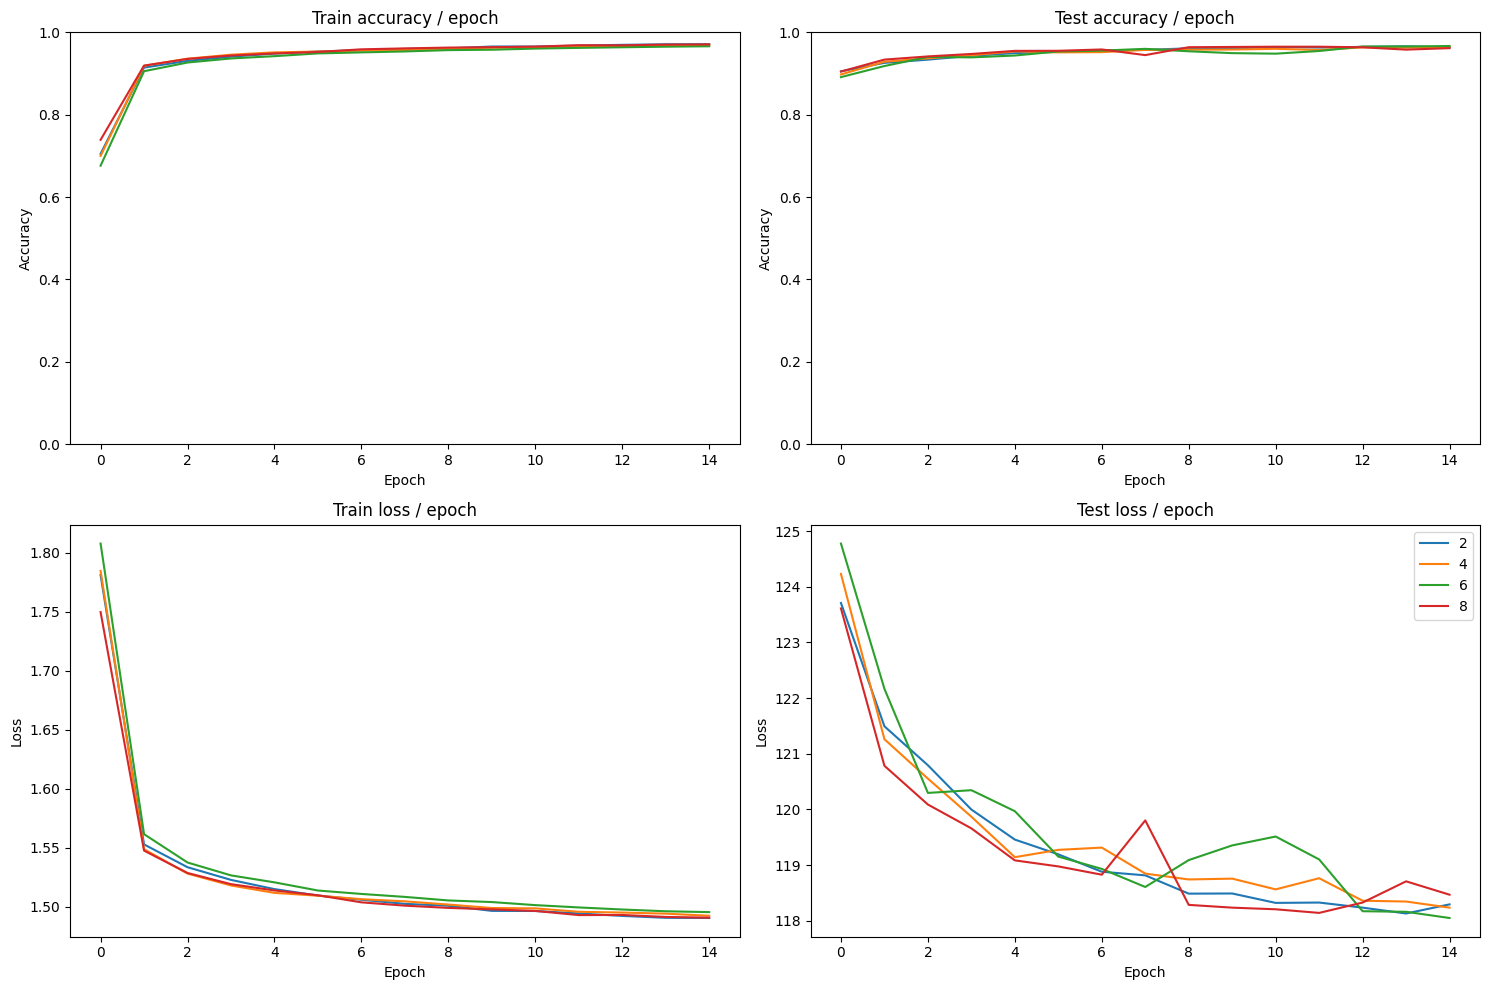

In [26]:
plot_plot_optimizers(plot_optimizers_mlp_ratio, 'mlp_ratio_influence')

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [27]:
%pip install timm > /dev/null

Note: you may need to restart the kernel to use updated packages.


a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [28]:
import timm
# [k for k in timm.list_models() if 'vit_base' in k]

In [29]:
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
try:
    model(torch.randn(1, 1, 28, 28))
except AssertionError as err:
    print(err)

Input height (28) doesn't match model (224).


The model vit_base_patch16_224 is trained on 224x224 images from the ImageNet dataset. In the first layer of the ViT, the input image is divided into fixed-size patches to create embedded vectors. It's crucial to maintain the same image size as the one the model was designed for. 

In this case, it necessitates resizing the images to 224x224 RGB pixels. However, this may not be ideal as resizing could distort the images and potentially affect the model's performance.

In [30]:
x = torch.randn(32, 1, 28, 28)
x = x.repeat(1, 3, 8, 8) # adapt number of channels to fit in ViT 
# by coping the image and not resizing yet (see next cell)
display(x.size())
model(x).shape

torch.Size([32, 3, 224, 224])

torch.Size([32, 10])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [31]:
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
data_cfg # figure out which transformations were used for a given pretrained model

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [32]:
transform = timm.data.create_transform(**data_cfg)
transform_rgb = lambda x: transform(x.convert('RGB'))

In [33]:
model.cuda()
train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform_rgb)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=64)

c) redo the training with the pretrained ViT-S




In [34]:
# stats_vit = main(model=model, epochs=5, tqdm_batch=True)

In [35]:
# fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# ax = ax.flatten()

# ax[0].plot(stats_vit[0])
# ax[1].plot(stats_vit[1])
# ax[2].plot(stats_vit[2])
# ax[3].plot(stats_vit[3])

# ax[0].set_title("Train accuracy / epoch")
# ax[0].set_xlabel("Epoch")
# ax[0].set_ylabel("Accuracy")
# ax[0].set_ylim([0, 1])

# ax[1].set_title("Test accuracy / epoch")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("Accuracy")
# ax[1].set_ylim([0, 1])

# ax[2].set_title("Train loss / epoch")
# ax[2].set_xlabel("Epoch")
# ax[2].set_ylabel("Loss")

# ax[3].set_title("Test loss / epoch")
# ax[3].set_xlabel("Epoch")
# ax[3].set_ylabel("Loss")

# plt.legend()
# plt.tight_layout()
# plt.savefig("stats_vit.pdf", dpi=100, bbox_inches="tight")
# plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

In [36]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10).cuda()
stats_pretrained = main(model=model, epochs=5, tqdm_batch=True)

  0%|                                       | 0/938 [00:00<?, ?it/s]

  0%|                                         | 0/5 [00:00<?, ?it/s]

  0%|                               | 1/938 [00:00<08:41,  1.80it/s]

  0%|                               | 2/938 [00:01<08:33,  1.82it/s]

  0%|                               | 3/938 [00:01<08:29,  1.83it/s]

  0%|▏                              | 4/938 [00:02<08:28,  1.84it/s]

  1%|▏                              | 5/938 [00:02<08:27,  1.84it/s]

  1%|▏                              | 6/938 [00:03<08:31,  1.82it/s]

  1%|▏                              | 7/938 [00:03<08:34,  1.81it/s]

  1%|▎                              | 8/938 [00:04<08:35,  1.80it/s]

  1%|▎                              | 9/938 [00:04<08:36,  1.80it/s]

  1%|▎                             | 10/938 [00:05<08:37,  1.79it/s]

  1%|▎                             | 11/938 [00:06<08:37,  1.79it/s]

  1%|▍                             | 12/938 [00:06<08:37,  1.79it/s]

  1%|▍                             | 13/938 [00:07<08:37,  1.79it/s]

  1%|▍                             | 14/938 [00:07<08:36,  1.79it/s]

  2%|▍                             | 15/938 [00:08<08:32,  1.80it/s]

  2%|▌                             | 16/938 [00:08<08:28,  1.81it/s]

  2%|▌                             | 17/938 [00:09<08:26,  1.82it/s]

  2%|▌                             | 18/938 [00:09<08:27,  1.81it/s]

  2%|▌                             | 19/938 [00:10<08:25,  1.82it/s]

  2%|▋                             | 20/938 [00:11<08:23,  1.82it/s]

  2%|▋                             | 21/938 [00:11<08:22,  1.83it/s]

  2%|▋                             | 22/938 [00:12<08:20,  1.83it/s]

  2%|▋                             | 23/938 [00:12<08:19,  1.83it/s]

  3%|▊                             | 24/938 [00:13<08:18,  1.83it/s]

  3%|▊                             | 25/938 [00:13<08:18,  1.83it/s]

  3%|▊                             | 26/938 [00:14<08:17,  1.83it/s]

  3%|▊                             | 27/938 [00:14<08:17,  1.83it/s]

  3%|▉                             | 28/938 [00:15<08:17,  1.83it/s]

  3%|▉                             | 29/938 [00:15<08:16,  1.83it/s]

  3%|▉                             | 30/938 [00:16<08:16,  1.83it/s]

  3%|▉                             | 31/938 [00:17<08:15,  1.83it/s]

  3%|█                             | 32/938 [00:17<08:15,  1.83it/s]

  4%|█                             | 33/938 [00:18<08:14,  1.83it/s]

  4%|█                             | 34/938 [00:18<08:14,  1.83it/s]

  4%|█                             | 35/938 [00:19<08:14,  1.83it/s]

  4%|█▏                            | 36/938 [00:19<08:14,  1.82it/s]

  4%|█▏                            | 37/938 [00:20<08:13,  1.83it/s]

  4%|█▏                            | 38/938 [00:20<08:12,  1.83it/s]

  4%|█▏                            | 39/938 [00:21<08:12,  1.83it/s]

  4%|█▎                            | 40/938 [00:21<08:11,  1.83it/s]

  4%|█▎                            | 41/938 [00:22<08:11,  1.82it/s]

  4%|█▎                            | 42/938 [00:23<08:10,  1.83it/s]

  5%|█▍                            | 43/938 [00:23<08:10,  1.83it/s]

  5%|█▍                            | 44/938 [00:24<08:09,  1.83it/s]

  5%|█▍                            | 45/938 [00:24<08:09,  1.82it/s]

  5%|█▍                            | 46/938 [00:25<08:09,  1.82it/s]

  5%|█▌                            | 47/938 [00:25<08:08,  1.83it/s]

  5%|█▌                            | 48/938 [00:26<08:08,  1.82it/s]

  5%|█▌                            | 49/938 [00:26<08:07,  1.82it/s]

  5%|█▌                            | 50/938 [00:27<08:07,  1.82it/s]

  5%|█▋                            | 51/938 [00:28<08:06,  1.82it/s]

  6%|█▋                            | 52/938 [00:28<08:06,  1.82it/s]

  6%|█▋                            | 53/938 [00:29<08:10,  1.81it/s]

  6%|█▋                            | 54/938 [00:29<08:11,  1.80it/s]

  6%|█▊                            | 55/938 [00:30<08:13,  1.79it/s]

  6%|█▊                            | 56/938 [00:30<08:13,  1.79it/s]

  6%|█▊                            | 57/938 [00:31<08:14,  1.78it/s]

  6%|█▊                            | 58/938 [00:31<08:14,  1.78it/s]

  6%|█▉                            | 59/938 [00:32<08:15,  1.77it/s]

  6%|█▉                            | 60/938 [00:33<08:15,  1.77it/s]

  7%|█▉                            | 61/938 [00:33<08:15,  1.77it/s]

  7%|█▉                            | 62/938 [00:34<08:15,  1.77it/s]

  7%|██                            | 63/938 [00:34<08:14,  1.77it/s]

  7%|██                            | 64/938 [00:35<08:14,  1.77it/s]

  7%|██                            | 65/938 [00:35<08:14,  1.77it/s]

  7%|██                            | 66/938 [00:36<08:13,  1.77it/s]

  7%|██▏                           | 67/938 [00:37<08:13,  1.76it/s]

  7%|██▏                           | 68/938 [00:37<08:12,  1.77it/s]

  7%|██▏                           | 69/938 [00:38<08:12,  1.77it/s]

  7%|██▏                           | 70/938 [00:38<08:11,  1.77it/s]

  8%|██▎                           | 71/938 [00:39<08:11,  1.77it/s]

  8%|██▎                           | 72/938 [00:39<08:10,  1.77it/s]

  8%|██▎                           | 73/938 [00:40<08:09,  1.77it/s]

  8%|██▎                           | 74/938 [00:41<08:09,  1.76it/s]

  8%|██▍                           | 75/938 [00:41<08:08,  1.77it/s]

  8%|██▍                           | 76/938 [00:42<08:06,  1.77it/s]

  8%|██▍                           | 77/938 [00:42<08:02,  1.79it/s]

  8%|██▍                           | 78/938 [00:43<08:03,  1.78it/s]

  8%|██▌                           | 79/938 [00:43<08:04,  1.77it/s]

  9%|██▌                           | 80/938 [00:44<08:04,  1.77it/s]

  9%|██▌                           | 81/938 [00:44<08:04,  1.77it/s]

  9%|██▌                           | 82/938 [00:45<08:04,  1.77it/s]

  9%|██▋                           | 83/938 [00:46<08:04,  1.76it/s]

  9%|██▋                           | 84/938 [00:46<08:04,  1.76it/s]

  9%|██▋                           | 85/938 [00:47<08:04,  1.76it/s]

  9%|██▊                           | 86/938 [00:47<08:03,  1.76it/s]

  9%|██▊                           | 87/938 [00:48<08:03,  1.76it/s]

  9%|██▊                           | 88/938 [00:48<08:02,  1.76it/s]

  9%|██▊                           | 89/938 [00:49<08:02,  1.76it/s]

 10%|██▉                           | 90/938 [00:50<08:01,  1.76it/s]

 10%|██▉                           | 91/938 [00:50<08:01,  1.76it/s]

 10%|██▉                           | 92/938 [00:51<08:01,  1.76it/s]

 10%|██▉                           | 93/938 [00:51<08:00,  1.76it/s]

 10%|███                           | 94/938 [00:52<07:59,  1.76it/s]

 10%|███                           | 95/938 [00:52<07:58,  1.76it/s]

 10%|███                           | 96/938 [00:53<07:59,  1.76it/s]

 10%|███                           | 97/938 [00:54<07:58,  1.76it/s]

 10%|███▏                          | 98/938 [00:54<07:57,  1.76it/s]

 11%|███▏                          | 99/938 [00:55<07:57,  1.76it/s]

 11%|███                          | 100/938 [00:55<07:56,  1.76it/s]

 11%|███                          | 101/938 [00:56<07:56,  1.76it/s]

 11%|███▏                         | 102/938 [00:56<07:55,  1.76it/s]

 11%|███▏                         | 103/938 [00:57<07:55,  1.76it/s]

 11%|███▏                         | 104/938 [00:58<07:54,  1.76it/s]

 11%|███▏                         | 105/938 [00:58<07:54,  1.76it/s]

 11%|███▎                         | 106/938 [00:59<07:53,  1.76it/s]

 11%|███▎                         | 107/938 [00:59<07:52,  1.76it/s]

 12%|███▎                         | 108/938 [01:00<07:51,  1.76it/s]

 12%|███▎                         | 109/938 [01:00<07:51,  1.76it/s]

 12%|███▍                         | 110/938 [01:01<07:50,  1.76it/s]

 12%|███▍                         | 111/938 [01:02<07:50,  1.76it/s]

 12%|███▍                         | 112/938 [01:02<07:49,  1.76it/s]

 12%|███▍                         | 113/938 [01:03<07:49,  1.76it/s]

 12%|███▌                         | 114/938 [01:03<07:49,  1.76it/s]

 12%|███▌                         | 115/938 [01:04<07:48,  1.76it/s]

 12%|███▌                         | 116/938 [01:04<07:47,  1.76it/s]

 12%|███▌                         | 117/938 [01:05<07:47,  1.76it/s]

 13%|███▋                         | 118/938 [01:05<07:46,  1.76it/s]

 13%|███▋                         | 119/938 [01:06<07:45,  1.76it/s]

 13%|███▋                         | 120/938 [01:07<07:42,  1.77it/s]

 13%|███▋                         | 121/938 [01:07<07:39,  1.78it/s]

 13%|███▊                         | 122/938 [01:08<07:37,  1.78it/s]

 13%|███▊                         | 123/938 [01:08<07:35,  1.79it/s]

 13%|███▊                         | 124/938 [01:09<07:33,  1.79it/s]

 13%|███▊                         | 125/938 [01:09<07:32,  1.80it/s]

 13%|███▉                         | 126/938 [01:10<07:31,  1.80it/s]

 14%|███▉                         | 127/938 [01:11<07:30,  1.80it/s]

 14%|███▉                         | 128/938 [01:11<07:29,  1.80it/s]

 14%|███▉                         | 129/938 [01:12<07:41,  1.75it/s]

 14%|████                         | 130/938 [01:12<07:41,  1.75it/s]

 14%|████                         | 131/938 [01:13<07:40,  1.75it/s]

 14%|████                         | 132/938 [01:13<07:39,  1.75it/s]

 14%|████                         | 133/938 [01:14<07:38,  1.75it/s]

 14%|████▏                        | 134/938 [01:15<07:38,  1.75it/s]

 14%|████▏                        | 135/938 [01:15<07:37,  1.75it/s]

 14%|████▏                        | 136/938 [01:16<07:37,  1.75it/s]

 15%|████▏                        | 137/938 [01:16<07:36,  1.75it/s]

 15%|████▎                        | 138/938 [01:17<07:35,  1.76it/s]

 15%|████▎                        | 139/938 [01:17<07:34,  1.76it/s]

 15%|████▎                        | 140/938 [01:18<07:34,  1.76it/s]

 15%|████▎                        | 141/938 [01:19<07:33,  1.76it/s]

 15%|████▍                        | 142/938 [01:19<07:33,  1.76it/s]

 15%|████▍                        | 143/938 [01:20<07:32,  1.76it/s]

 15%|████▍                        | 144/938 [01:20<07:32,  1.76it/s]

 15%|████▍                        | 145/938 [01:21<07:31,  1.76it/s]

 16%|████▌                        | 146/938 [01:21<07:27,  1.77it/s]

 16%|████▌                        | 147/938 [01:22<07:29,  1.76it/s]

 16%|████▌                        | 148/938 [01:22<07:25,  1.77it/s]

 16%|████▌                        | 149/938 [01:23<07:23,  1.78it/s]

 16%|████▋                        | 150/938 [01:24<07:21,  1.79it/s]

 16%|████▋                        | 151/938 [01:24<07:19,  1.79it/s]

 16%|████▋                        | 152/938 [01:25<07:18,  1.79it/s]

 16%|████▋                        | 153/938 [01:25<07:17,  1.80it/s]

 16%|████▊                        | 154/938 [01:26<07:16,  1.80it/s]

 17%|████▊                        | 155/938 [01:26<07:15,  1.80it/s]

 17%|████▊                        | 156/938 [01:27<07:14,  1.80it/s]

 17%|████▊                        | 157/938 [01:27<07:14,  1.80it/s]

 17%|████▉                        | 158/938 [01:28<07:13,  1.80it/s]

 17%|████▉                        | 159/938 [01:29<07:12,  1.80it/s]

 17%|████▉                        | 160/938 [01:29<07:12,  1.80it/s]

 17%|████▉                        | 161/938 [01:30<07:11,  1.80it/s]

 17%|█████                        | 162/938 [01:30<07:11,  1.80it/s]

 17%|█████                        | 163/938 [01:31<07:10,  1.80it/s]

 17%|█████                        | 164/938 [01:31<07:10,  1.80it/s]

 18%|█████                        | 165/938 [01:32<07:09,  1.80it/s]

 18%|█████▏                       | 166/938 [01:32<07:09,  1.80it/s]

 18%|█████▏                       | 167/938 [01:33<07:09,  1.80it/s]

 18%|█████▏                       | 168/938 [01:34<07:08,  1.80it/s]

 18%|█████▏                       | 169/938 [01:34<07:07,  1.80it/s]

 18%|█████▎                       | 170/938 [01:35<07:07,  1.80it/s]

 18%|█████▎                       | 171/938 [01:35<07:06,  1.80it/s]

 18%|█████▎                       | 172/938 [01:36<07:06,  1.80it/s]

 18%|█████▎                       | 173/938 [01:36<07:05,  1.80it/s]

 19%|█████▍                       | 174/938 [01:37<07:04,  1.80it/s]

 19%|█████▍                       | 175/938 [01:37<07:03,  1.80it/s]

 19%|█████▍                       | 176/938 [01:38<07:03,  1.80it/s]

 19%|█████▍                       | 177/938 [01:39<07:02,  1.80it/s]

 19%|█████▌                       | 178/938 [01:39<07:01,  1.80it/s]

 19%|█████▌                       | 179/938 [01:40<07:01,  1.80it/s]

 19%|█████▌                       | 180/938 [01:40<07:00,  1.80it/s]

 19%|█████▌                       | 181/938 [01:41<07:00,  1.80it/s]

 19%|█████▋                       | 182/938 [01:41<06:59,  1.80it/s]

 20%|█████▋                       | 183/938 [01:42<06:59,  1.80it/s]

 20%|█████▋                       | 184/938 [01:42<06:58,  1.80it/s]

 20%|█████▋                       | 185/938 [01:43<06:58,  1.80it/s]

 20%|█████▊                       | 186/938 [01:44<06:57,  1.80it/s]

 20%|█████▊                       | 187/938 [01:44<06:57,  1.80it/s]

 20%|█████▊                       | 188/938 [01:45<06:56,  1.80it/s]

 20%|█████▊                       | 189/938 [01:45<06:56,  1.80it/s]

 20%|█████▊                       | 190/938 [01:46<06:55,  1.80it/s]

 20%|█████▉                       | 191/938 [01:46<06:55,  1.80it/s]

 20%|█████▉                       | 192/938 [01:47<06:54,  1.80it/s]

 21%|█████▉                       | 193/938 [01:47<06:53,  1.80it/s]

 21%|█████▉                       | 194/938 [01:48<06:53,  1.80it/s]

 21%|██████                       | 195/938 [01:49<06:52,  1.80it/s]

 21%|██████                       | 196/938 [01:49<06:52,  1.80it/s]

 21%|██████                       | 197/938 [01:50<06:51,  1.80it/s]

 21%|██████                       | 198/938 [01:50<06:51,  1.80it/s]

 21%|██████▏                      | 199/938 [01:51<06:51,  1.80it/s]

 21%|██████▏                      | 200/938 [01:51<06:51,  1.79it/s]

 21%|██████▏                      | 201/938 [01:52<06:51,  1.79it/s]

 22%|██████▏                      | 202/938 [01:52<06:50,  1.79it/s]

 22%|██████▎                      | 203/938 [01:53<06:49,  1.79it/s]

 22%|██████▎                      | 204/938 [01:54<06:48,  1.79it/s]

 22%|██████▎                      | 205/938 [01:54<06:48,  1.80it/s]

 22%|██████▎                      | 206/938 [01:55<06:47,  1.80it/s]

 22%|██████▍                      | 207/938 [01:55<06:47,  1.80it/s]

 22%|██████▍                      | 208/938 [01:56<06:46,  1.79it/s]

 22%|██████▍                      | 209/938 [01:56<06:46,  1.79it/s]

 22%|██████▍                      | 210/938 [01:57<06:45,  1.79it/s]

 22%|██████▌                      | 211/938 [01:57<06:45,  1.79it/s]

 23%|██████▌                      | 212/938 [01:58<06:44,  1.80it/s]

 23%|██████▌                      | 213/938 [01:59<06:43,  1.80it/s]

 23%|██████▌                      | 214/938 [01:59<06:43,  1.79it/s]

 23%|██████▋                      | 215/938 [02:00<06:42,  1.79it/s]

 23%|██████▋                      | 216/938 [02:00<06:42,  1.79it/s]

 23%|██████▋                      | 217/938 [02:01<06:42,  1.79it/s]

 23%|██████▋                      | 218/938 [02:01<06:41,  1.79it/s]

 23%|██████▊                      | 219/938 [02:02<06:40,  1.79it/s]

 23%|██████▊                      | 220/938 [02:03<06:40,  1.79it/s]

 24%|██████▊                      | 221/938 [02:03<06:39,  1.79it/s]

 24%|██████▊                      | 222/938 [02:04<06:38,  1.80it/s]

 24%|██████▉                      | 223/938 [02:04<06:38,  1.79it/s]

 24%|██████▉                      | 224/938 [02:05<06:38,  1.79it/s]

 24%|██████▉                      | 225/938 [02:05<06:38,  1.79it/s]

 24%|██████▉                      | 226/938 [02:06<06:37,  1.79it/s]

 24%|███████                      | 227/938 [02:06<06:36,  1.79it/s]

 24%|███████                      | 228/938 [02:07<06:35,  1.79it/s]

 24%|███████                      | 229/938 [02:08<06:35,  1.79it/s]

 25%|███████                      | 230/938 [02:08<06:34,  1.79it/s]

 25%|███████▏                     | 231/938 [02:09<06:33,  1.80it/s]

 25%|███████▏                     | 232/938 [02:09<06:33,  1.79it/s]

 25%|███████▏                     | 233/938 [02:10<06:32,  1.79it/s]

 25%|███████▏                     | 234/938 [02:10<06:32,  1.79it/s]

 25%|███████▎                     | 235/938 [02:11<06:31,  1.79it/s]

 25%|███████▎                     | 236/938 [02:11<06:31,  1.79it/s]

 25%|███████▎                     | 237/938 [02:12<06:30,  1.79it/s]

 25%|███████▎                     | 238/938 [02:13<06:29,  1.80it/s]

 25%|███████▍                     | 239/938 [02:13<06:29,  1.79it/s]

 26%|███████▍                     | 240/938 [02:14<06:29,  1.79it/s]

 26%|███████▍                     | 241/938 [02:14<06:28,  1.79it/s]

 26%|███████▍                     | 242/938 [02:15<06:27,  1.79it/s]

 26%|███████▌                     | 243/938 [02:15<06:27,  1.79it/s]

 26%|███████▌                     | 244/938 [02:16<06:26,  1.80it/s]

 26%|███████▌                     | 245/938 [02:16<06:25,  1.80it/s]

 26%|███████▌                     | 246/938 [02:17<06:25,  1.80it/s]

 26%|███████▋                     | 247/938 [02:18<06:24,  1.80it/s]

 26%|███████▋                     | 248/938 [02:18<06:23,  1.80it/s]

 27%|███████▋                     | 249/938 [02:19<06:23,  1.80it/s]

 27%|███████▋                     | 250/938 [02:19<06:22,  1.80it/s]

 27%|███████▊                     | 251/938 [02:20<06:21,  1.80it/s]

 27%|███████▊                     | 252/938 [02:20<06:21,  1.80it/s]

 27%|███████▊                     | 253/938 [02:21<06:20,  1.80it/s]

 27%|███████▊                     | 254/938 [02:21<06:20,  1.80it/s]

 27%|███████▉                     | 255/938 [02:22<06:19,  1.80it/s]

 27%|███████▉                     | 256/938 [02:23<06:18,  1.80it/s]

 27%|███████▉                     | 257/938 [02:23<06:18,  1.80it/s]

 28%|███████▉                     | 258/938 [02:24<06:18,  1.80it/s]

 28%|████████                     | 259/938 [02:24<06:17,  1.80it/s]

 28%|████████                     | 260/938 [02:25<06:16,  1.80it/s]

 28%|████████                     | 261/938 [02:25<06:15,  1.80it/s]

 28%|████████                     | 262/938 [02:26<06:15,  1.80it/s]

 28%|████████▏                    | 263/938 [02:26<06:15,  1.80it/s]

 28%|████████▏                    | 264/938 [02:27<06:14,  1.80it/s]

 28%|████████▏                    | 265/938 [02:28<06:13,  1.80it/s]

 28%|████████▏                    | 266/938 [02:28<06:13,  1.80it/s]

 28%|████████▎                    | 267/938 [02:29<06:13,  1.80it/s]

 29%|████████▎                    | 268/938 [02:29<06:12,  1.80it/s]

 29%|████████▎                    | 269/938 [02:30<06:11,  1.80it/s]

 29%|████████▎                    | 270/938 [02:30<06:11,  1.80it/s]

 29%|████████▍                    | 271/938 [02:31<06:15,  1.78it/s]

 29%|████████▍                    | 272/938 [02:31<06:13,  1.78it/s]

 29%|████████▍                    | 273/938 [02:32<06:12,  1.79it/s]

 29%|████████▍                    | 274/938 [02:33<06:10,  1.79it/s]

 29%|████████▌                    | 275/938 [02:33<06:14,  1.77it/s]

 29%|████████▌                    | 276/938 [02:34<06:12,  1.78it/s]

 30%|████████▌                    | 277/938 [02:34<06:10,  1.79it/s]

 30%|████████▌                    | 278/938 [02:35<06:08,  1.79it/s]

 30%|████████▋                    | 279/938 [02:35<06:07,  1.79it/s]

 30%|████████▋                    | 280/938 [02:36<06:06,  1.79it/s]

 30%|████████▋                    | 281/938 [02:37<06:05,  1.80it/s]

 30%|████████▋                    | 282/938 [02:37<06:04,  1.80it/s]

 30%|████████▋                    | 283/938 [02:38<06:04,  1.80it/s]

 30%|████████▊                    | 284/938 [02:38<06:03,  1.80it/s]

 30%|████████▊                    | 285/938 [02:39<06:02,  1.80it/s]

 30%|████████▊                    | 286/938 [02:39<06:02,  1.80it/s]

 31%|████████▊                    | 287/938 [02:40<06:01,  1.80it/s]

 31%|████████▉                    | 288/938 [02:40<06:01,  1.80it/s]

 31%|████████▉                    | 289/938 [02:41<06:00,  1.80it/s]

 31%|████████▉                    | 290/938 [02:42<06:00,  1.80it/s]

 31%|████████▉                    | 291/938 [02:42<05:59,  1.80it/s]

 31%|█████████                    | 292/938 [02:43<05:58,  1.80it/s]

 31%|█████████                    | 293/938 [02:43<05:58,  1.80it/s]

 31%|█████████                    | 294/938 [02:44<05:57,  1.80it/s]

 31%|█████████                    | 295/938 [02:44<05:57,  1.80it/s]

 32%|█████████▏                   | 296/938 [02:45<05:56,  1.80it/s]

 32%|█████████▏                   | 297/938 [02:45<05:56,  1.80it/s]

 32%|█████████▏                   | 298/938 [02:46<05:55,  1.80it/s]

 32%|█████████▏                   | 299/938 [02:47<05:54,  1.80it/s]

 32%|█████████▎                   | 300/938 [02:47<05:54,  1.80it/s]

 32%|█████████▎                   | 301/938 [02:48<05:53,  1.80it/s]

 32%|█████████▎                   | 302/938 [02:48<05:53,  1.80it/s]

 32%|█████████▎                   | 303/938 [02:49<05:53,  1.80it/s]

 32%|█████████▍                   | 304/938 [02:49<05:53,  1.79it/s]

 33%|█████████▍                   | 305/938 [02:50<05:52,  1.79it/s]

 33%|█████████▍                   | 306/938 [02:50<05:52,  1.79it/s]

 33%|█████████▍                   | 307/938 [02:51<05:51,  1.80it/s]

 33%|█████████▌                   | 308/938 [02:52<05:50,  1.80it/s]

 33%|█████████▌                   | 309/938 [02:52<05:50,  1.80it/s]

 33%|█████████▌                   | 310/938 [02:53<05:49,  1.80it/s]

 33%|█████████▌                   | 311/938 [02:53<05:49,  1.79it/s]

 33%|█████████▋                   | 312/938 [02:54<05:52,  1.77it/s]

 33%|█████████▋                   | 313/938 [02:54<05:51,  1.78it/s]

 33%|█████████▋                   | 314/938 [02:55<05:49,  1.78it/s]

 34%|█████████▋                   | 315/938 [02:55<05:48,  1.79it/s]

 34%|█████████▊                   | 316/938 [02:56<05:47,  1.79it/s]

 34%|█████████▊                   | 317/938 [02:57<05:46,  1.79it/s]

 34%|█████████▊                   | 318/938 [02:57<05:45,  1.79it/s]

 34%|█████████▊                   | 319/938 [02:58<05:44,  1.80it/s]

 34%|█████████▉                   | 320/938 [02:58<05:43,  1.80it/s]

 34%|█████████▉                   | 321/938 [02:59<05:43,  1.80it/s]

 34%|█████████▉                   | 322/938 [02:59<05:42,  1.80it/s]

 34%|█████████▉                   | 323/938 [03:00<05:42,  1.80it/s]

 35%|██████████                   | 324/938 [03:00<05:42,  1.79it/s]

 35%|██████████                   | 325/938 [03:01<05:41,  1.79it/s]

 35%|██████████                   | 326/938 [03:02<05:40,  1.80it/s]

 35%|██████████                   | 327/938 [03:02<05:40,  1.80it/s]

 35%|██████████▏                  | 328/938 [03:03<05:39,  1.80it/s]

 35%|██████████▏                  | 329/938 [03:03<05:38,  1.80it/s]

 35%|██████████▏                  | 330/938 [03:04<05:38,  1.80it/s]

 35%|██████████▏                  | 331/938 [03:04<05:37,  1.80it/s]

 35%|██████████▎                  | 332/938 [03:05<05:37,  1.80it/s]

 36%|██████████▎                  | 333/938 [03:05<05:36,  1.80it/s]

 36%|██████████▎                  | 334/938 [03:06<05:35,  1.80it/s]

 36%|██████████▎                  | 335/938 [03:07<05:35,  1.80it/s]

 36%|██████████▍                  | 336/938 [03:07<05:34,  1.80it/s]

 36%|██████████▍                  | 337/938 [03:08<05:34,  1.80it/s]

 36%|██████████▍                  | 338/938 [03:08<05:33,  1.80it/s]

 36%|██████████▍                  | 339/938 [03:09<05:32,  1.80it/s]

 36%|██████████▌                  | 340/938 [03:09<05:32,  1.80it/s]

 36%|██████████▌                  | 341/938 [03:10<05:32,  1.80it/s]

 36%|██████████▌                  | 342/938 [03:10<05:31,  1.80it/s]

 37%|██████████▌                  | 343/938 [03:11<05:35,  1.77it/s]

 37%|██████████▋                  | 344/938 [03:12<05:33,  1.78it/s]

 37%|██████████▋                  | 345/938 [03:12<05:31,  1.79it/s]

 37%|██████████▋                  | 346/938 [03:13<05:30,  1.79it/s]

 37%|██████████▋                  | 347/938 [03:13<05:29,  1.79it/s]

 37%|██████████▊                  | 348/938 [03:14<05:28,  1.80it/s]

 37%|██████████▊                  | 349/938 [03:14<05:27,  1.80it/s]

 37%|██████████▊                  | 350/938 [03:15<05:27,  1.80it/s]

 37%|██████████▊                  | 351/938 [03:15<05:26,  1.80it/s]

 38%|██████████▉                  | 352/938 [03:16<05:25,  1.80it/s]

 38%|██████████▉                  | 353/938 [03:17<05:25,  1.80it/s]

 38%|██████████▉                  | 354/938 [03:17<05:24,  1.80it/s]

 38%|██████████▉                  | 355/938 [03:18<05:24,  1.80it/s]

 38%|███████████                  | 356/938 [03:18<05:26,  1.78it/s]

 38%|███████████                  | 357/938 [03:19<05:27,  1.78it/s]

 38%|███████████                  | 358/938 [03:19<05:27,  1.77it/s]

 38%|███████████                  | 359/938 [03:20<05:27,  1.77it/s]

 38%|███████████▏                 | 360/938 [03:21<05:27,  1.76it/s]

 38%|███████████▏                 | 361/938 [03:21<05:27,  1.76it/s]

 39%|███████████▏                 | 362/938 [03:22<05:27,  1.76it/s]

 39%|███████████▏                 | 363/938 [03:22<05:27,  1.76it/s]

 39%|███████████▎                 | 364/938 [03:23<05:26,  1.76it/s]

 39%|███████████▎                 | 365/938 [03:23<05:26,  1.76it/s]

 39%|███████████▎                 | 366/938 [03:24<05:25,  1.76it/s]

 39%|███████████▎                 | 367/938 [03:25<05:22,  1.77it/s]

 39%|███████████▍                 | 368/938 [03:25<05:20,  1.78it/s]

 39%|███████████▍                 | 369/938 [03:26<05:18,  1.78it/s]

 39%|███████████▍                 | 370/938 [03:26<05:17,  1.79it/s]

 40%|███████████▍                 | 371/938 [03:27<05:16,  1.79it/s]

 40%|███████████▌                 | 372/938 [03:27<05:15,  1.79it/s]

 40%|███████████▌                 | 373/938 [03:28<05:17,  1.78it/s]

 40%|███████████▌                 | 374/938 [03:28<05:17,  1.78it/s]

 40%|███████████▌                 | 375/938 [03:29<05:15,  1.78it/s]

 40%|███████████▌                 | 376/938 [03:30<05:14,  1.79it/s]

 40%|███████████▋                 | 377/938 [03:30<05:13,  1.79it/s]

 40%|███████████▋                 | 378/938 [03:31<05:22,  1.74it/s]

 40%|███████████▋                 | 379/938 [03:31<05:21,  1.74it/s]

 41%|███████████▋                 | 380/938 [03:32<05:20,  1.74it/s]

 41%|███████████▊                 | 381/938 [03:32<05:18,  1.75it/s]

 41%|███████████▊                 | 382/938 [03:33<05:18,  1.75it/s]

 41%|███████████▊                 | 383/938 [03:34<05:17,  1.75it/s]

 41%|███████████▊                 | 384/938 [03:34<05:16,  1.75it/s]

 41%|███████████▉                 | 385/938 [03:35<05:16,  1.75it/s]

 41%|███████████▉                 | 386/938 [03:35<05:15,  1.75it/s]

 41%|███████████▉                 | 387/938 [03:36<05:12,  1.76it/s]

 41%|███████████▉                 | 388/938 [03:36<05:10,  1.77it/s]

 41%|████████████                 | 389/938 [03:37<05:08,  1.78it/s]

 42%|████████████                 | 390/938 [03:38<05:06,  1.79it/s]

 42%|████████████                 | 391/938 [03:38<05:08,  1.77it/s]

 42%|████████████                 | 392/938 [03:39<05:09,  1.77it/s]

 42%|████████████▏                | 393/938 [03:39<05:09,  1.76it/s]

 42%|████████████▏                | 394/938 [03:40<05:09,  1.76it/s]

 42%|████████████▏                | 395/938 [03:40<05:09,  1.75it/s]

 42%|████████████▏                | 396/938 [03:41<05:09,  1.75it/s]

 42%|████████████▎                | 397/938 [03:42<05:08,  1.75it/s]

 42%|████████████▎                | 398/938 [03:42<05:08,  1.75it/s]

 43%|████████████▎                | 399/938 [03:43<05:07,  1.75it/s]

 43%|████████████▎                | 400/938 [03:43<05:07,  1.75it/s]

 43%|████████████▍                | 401/938 [03:44<05:06,  1.75it/s]

 43%|████████████▍                | 402/938 [03:44<05:06,  1.75it/s]

 43%|████████████▍                | 403/938 [03:45<05:05,  1.75it/s]

 43%|████████████▍                | 404/938 [03:46<05:05,  1.75it/s]

 43%|████████████▌                | 405/938 [03:46<05:04,  1.75it/s]

 43%|████████████▌                | 406/938 [03:47<05:04,  1.75it/s]

 43%|████████████▌                | 407/938 [03:47<05:03,  1.75it/s]

 43%|████████████▌                | 408/938 [03:48<05:02,  1.75it/s]

 44%|████████████▋                | 409/938 [03:48<05:02,  1.75it/s]

 44%|████████████▋                | 410/938 [03:49<05:01,  1.75it/s]

 44%|████████████▋                | 411/938 [03:50<05:01,  1.75it/s]

 44%|████████████▋                | 412/938 [03:50<05:00,  1.75it/s]

 44%|████████████▊                | 413/938 [03:51<05:00,  1.75it/s]

 44%|████████████▊                | 414/938 [03:51<04:59,  1.75it/s]

 44%|████████████▊                | 415/938 [03:52<04:59,  1.75it/s]

 44%|████████████▊                | 416/938 [03:52<04:58,  1.75it/s]

 44%|████████████▉                | 417/938 [03:53<04:57,  1.75it/s]

 45%|████████████▉                | 418/938 [03:54<04:57,  1.75it/s]

 45%|████████████▉                | 419/938 [03:54<04:56,  1.75it/s]

 45%|████████████▉                | 420/938 [03:55<04:55,  1.75it/s]

 45%|█████████████                | 421/938 [03:55<04:55,  1.75it/s]

 45%|█████████████                | 422/938 [03:56<04:54,  1.75it/s]

 45%|█████████████                | 423/938 [03:56<04:54,  1.75it/s]

 45%|█████████████                | 424/938 [03:57<04:53,  1.75it/s]

 45%|█████████████▏               | 425/938 [03:58<04:52,  1.75it/s]

 45%|█████████████▏               | 426/938 [03:58<04:52,  1.75it/s]

 46%|█████████████▏               | 427/938 [03:59<04:51,  1.75it/s]

 46%|█████████████▏               | 428/938 [03:59<04:51,  1.75it/s]

 46%|█████████████▎               | 429/938 [04:00<04:51,  1.75it/s]

 46%|█████████████▎               | 430/938 [04:00<04:50,  1.75it/s]

 46%|█████████████▎               | 431/938 [04:01<04:50,  1.75it/s]

 46%|█████████████▎               | 432/938 [04:02<04:49,  1.75it/s]

 46%|█████████████▍               | 433/938 [04:02<04:48,  1.75it/s]

 46%|█████████████▍               | 434/938 [04:03<04:48,  1.75it/s]

 46%|█████████████▍               | 435/938 [04:03<04:47,  1.75it/s]

 46%|█████████████▍               | 436/938 [04:04<04:46,  1.75it/s]

 47%|█████████████▌               | 437/938 [04:04<04:46,  1.75it/s]

 47%|█████████████▌               | 438/938 [04:05<04:45,  1.75it/s]

 47%|█████████████▌               | 439/938 [04:06<04:44,  1.75it/s]

 47%|█████████████▌               | 440/938 [04:06<04:44,  1.75it/s]

 47%|█████████████▋               | 441/938 [04:07<04:44,  1.75it/s]

 47%|█████████████▋               | 442/938 [04:07<04:43,  1.75it/s]

 47%|█████████████▋               | 443/938 [04:08<04:42,  1.75it/s]

 47%|█████████████▋               | 444/938 [04:08<04:42,  1.75it/s]

 47%|█████████████▊               | 445/938 [04:09<04:41,  1.75it/s]

 48%|█████████████▊               | 446/938 [04:10<04:41,  1.75it/s]

 48%|█████████████▊               | 447/938 [04:10<04:40,  1.75it/s]

 48%|█████████████▊               | 448/938 [04:11<04:39,  1.75it/s]

 48%|█████████████▉               | 449/938 [04:11<04:39,  1.75it/s]

 48%|█████████████▉               | 450/938 [04:12<04:38,  1.75it/s]

 48%|█████████████▉               | 451/938 [04:12<04:38,  1.75it/s]

 48%|█████████████▉               | 452/938 [04:13<04:37,  1.75it/s]

 48%|██████████████               | 453/938 [04:14<04:37,  1.75it/s]

 48%|██████████████               | 454/938 [04:14<04:36,  1.75it/s]

 49%|██████████████               | 455/938 [04:15<04:35,  1.75it/s]

 49%|██████████████               | 456/938 [04:15<04:35,  1.75it/s]

 49%|██████████████▏              | 457/938 [04:16<04:34,  1.75it/s]

 49%|██████████████▏              | 458/938 [04:16<04:34,  1.75it/s]

 49%|██████████████▏              | 459/938 [04:17<04:33,  1.75it/s]

 49%|██████████████▏              | 460/938 [04:18<04:33,  1.75it/s]

 49%|██████████████▎              | 461/938 [04:18<04:32,  1.75it/s]

 49%|██████████████▎              | 462/938 [04:19<04:32,  1.75it/s]

 49%|██████████████▎              | 463/938 [04:19<04:31,  1.75it/s]

 49%|██████████████▎              | 464/938 [04:20<04:31,  1.75it/s]

 50%|██████████████▍              | 465/938 [04:20<04:30,  1.75it/s]

 50%|██████████████▍              | 466/938 [04:21<04:29,  1.75it/s]

 50%|██████████████▍              | 467/938 [04:22<04:29,  1.75it/s]

 50%|██████████████▍              | 468/938 [04:22<04:28,  1.75it/s]

 50%|██████████████▌              | 469/938 [04:23<04:27,  1.75it/s]

 50%|██████████████▌              | 470/938 [04:23<04:27,  1.75it/s]

 50%|██████████████▌              | 471/938 [04:24<04:26,  1.75it/s]

 50%|██████████████▌              | 472/938 [04:24<04:26,  1.75it/s]

 50%|██████████████▌              | 473/938 [04:25<04:25,  1.75it/s]

 51%|██████████████▋              | 474/938 [04:26<04:25,  1.75it/s]

 51%|██████████████▋              | 475/938 [04:26<04:24,  1.75it/s]

 51%|██████████████▋              | 476/938 [04:27<04:23,  1.75it/s]

 51%|██████████████▋              | 477/938 [04:27<04:23,  1.75it/s]

 51%|██████████████▊              | 478/938 [04:28<04:22,  1.75it/s]

 51%|██████████████▊              | 479/938 [04:28<04:21,  1.75it/s]

 51%|██████████████▊              | 480/938 [04:29<04:21,  1.75it/s]

 51%|██████████████▊              | 481/938 [04:30<04:20,  1.75it/s]

 51%|██████████████▉              | 482/938 [04:30<04:20,  1.75it/s]

 51%|██████████████▉              | 483/938 [04:31<04:19,  1.75it/s]

 52%|██████████████▉              | 484/938 [04:31<04:19,  1.75it/s]

 52%|██████████████▉              | 485/938 [04:32<04:18,  1.75it/s]

 52%|███████████████              | 486/938 [04:32<04:18,  1.75it/s]

 52%|███████████████              | 487/938 [04:33<04:17,  1.75it/s]

 52%|███████████████              | 488/938 [04:34<04:17,  1.75it/s]

 52%|███████████████              | 489/938 [04:34<04:16,  1.75it/s]

 52%|███████████████▏             | 490/938 [04:35<04:15,  1.75it/s]

 52%|███████████████▏             | 491/938 [04:35<04:15,  1.75it/s]

 52%|███████████████▏             | 492/938 [04:36<04:14,  1.75it/s]

 53%|███████████████▏             | 493/938 [04:36<04:14,  1.75it/s]

 53%|███████████████▎             | 494/938 [04:37<04:13,  1.75it/s]

 53%|███████████████▎             | 495/938 [04:38<04:13,  1.75it/s]

 53%|███████████████▎             | 496/938 [04:38<04:12,  1.75it/s]

 53%|███████████████▎             | 497/938 [04:39<04:12,  1.75it/s]

 53%|███████████████▍             | 498/938 [04:39<04:11,  1.75it/s]

 53%|███████████████▍             | 499/938 [04:40<04:10,  1.75it/s]

 53%|███████████████▍             | 500/938 [04:40<04:10,  1.75it/s]

 53%|███████████████▍             | 501/938 [04:41<04:09,  1.75it/s]

 54%|███████████████▌             | 502/938 [04:42<04:08,  1.75it/s]

 54%|███████████████▌             | 503/938 [04:42<04:08,  1.75it/s]

 54%|███████████████▌             | 504/938 [04:43<04:07,  1.75it/s]

 54%|███████████████▌             | 505/938 [04:43<04:07,  1.75it/s]

 54%|███████████████▋             | 506/938 [04:44<04:06,  1.75it/s]

 54%|███████████████▋             | 507/938 [04:44<04:03,  1.77it/s]

 54%|███████████████▋             | 508/938 [04:45<04:01,  1.78it/s]

 54%|███████████████▋             | 509/938 [04:45<04:03,  1.76it/s]

 54%|███████████████▊             | 510/938 [04:46<04:01,  1.77it/s]

 54%|███████████████▊             | 511/938 [04:47<03:59,  1.78it/s]

 55%|███████████████▊             | 512/938 [04:47<03:58,  1.79it/s]

 55%|███████████████▊             | 513/938 [04:48<03:57,  1.79it/s]

 55%|███████████████▉             | 514/938 [04:48<03:56,  1.79it/s]

 55%|███████████████▉             | 515/938 [04:49<03:55,  1.79it/s]

 55%|███████████████▉             | 516/938 [04:49<03:54,  1.80it/s]

 55%|███████████████▉             | 517/938 [04:50<03:56,  1.78it/s]

 55%|████████████████             | 518/938 [04:51<03:56,  1.77it/s]

 55%|████████████████             | 519/938 [04:51<03:57,  1.77it/s]

 55%|████████████████             | 520/938 [04:52<03:57,  1.76it/s]

 56%|████████████████             | 521/938 [04:52<03:57,  1.76it/s]

 56%|████████████████▏            | 522/938 [04:53<03:54,  1.77it/s]

 56%|████████████████▏            | 523/938 [04:53<03:53,  1.78it/s]

 56%|████████████████▏            | 524/938 [04:54<03:53,  1.77it/s]

 56%|████████████████▏            | 525/938 [04:54<03:54,  1.76it/s]

 56%|████████████████▎            | 526/938 [04:55<03:53,  1.76it/s]

 56%|████████████████▎            | 527/938 [04:56<03:53,  1.76it/s]

 56%|████████████████▎            | 528/938 [04:56<03:53,  1.76it/s]

 56%|████████████████▎            | 529/938 [04:57<03:52,  1.76it/s]

 57%|████████████████▍            | 530/938 [04:57<03:52,  1.75it/s]

 57%|████████████████▍            | 531/938 [04:58<03:52,  1.75it/s]

 57%|████████████████▍            | 532/938 [04:58<03:51,  1.75it/s]

 57%|████████████████▍            | 533/938 [04:59<03:51,  1.75it/s]

 57%|████████████████▌            | 534/938 [05:00<03:50,  1.75it/s]

 57%|████████████████▌            | 535/938 [05:00<03:50,  1.75it/s]

 57%|████████████████▌            | 536/938 [05:01<03:49,  1.75it/s]

 57%|████████████████▌            | 537/938 [05:01<03:48,  1.75it/s]

 57%|████████████████▋            | 538/938 [05:02<03:48,  1.75it/s]

 57%|████████████████▋            | 539/938 [05:02<03:47,  1.75it/s]

 58%|████████████████▋            | 540/938 [05:03<03:47,  1.75it/s]

 58%|████████████████▋            | 541/938 [05:04<03:46,  1.75it/s]

 58%|████████████████▊            | 542/938 [05:04<03:45,  1.75it/s]

 58%|████████████████▊            | 543/938 [05:05<03:45,  1.75it/s]

 58%|████████████████▊            | 544/938 [05:05<03:45,  1.75it/s]

 58%|████████████████▊            | 545/938 [05:06<03:44,  1.75it/s]

 58%|████████████████▉            | 546/938 [05:06<03:43,  1.75it/s]

 58%|████████████████▉            | 547/938 [05:07<03:43,  1.75it/s]

 58%|████████████████▉            | 548/938 [05:08<03:42,  1.75it/s]

 59%|████████████████▉            | 549/938 [05:08<03:41,  1.75it/s]

 59%|█████████████████            | 550/938 [05:09<03:41,  1.75it/s]

 59%|█████████████████            | 551/938 [05:09<03:40,  1.75it/s]

 59%|█████████████████            | 552/938 [05:10<03:40,  1.75it/s]

 59%|█████████████████            | 553/938 [05:10<03:39,  1.75it/s]

 59%|█████████████████▏           | 554/938 [05:11<03:39,  1.75it/s]

 59%|█████████████████▏           | 555/938 [05:12<03:38,  1.75it/s]

 59%|█████████████████▏           | 556/938 [05:12<03:38,  1.75it/s]

 59%|█████████████████▏           | 557/938 [05:13<03:37,  1.75it/s]

 59%|█████████████████▎           | 558/938 [05:13<03:36,  1.75it/s]

 60%|█████████████████▎           | 559/938 [05:14<03:36,  1.75it/s]

 60%|█████████████████▎           | 560/938 [05:14<03:35,  1.75it/s]

 60%|█████████████████▎           | 561/938 [05:15<03:35,  1.75it/s]

 60%|█████████████████▍           | 562/938 [05:16<03:34,  1.75it/s]

 60%|█████████████████▍           | 563/938 [05:16<03:33,  1.75it/s]

 60%|█████████████████▍           | 564/938 [05:17<03:33,  1.75it/s]

 60%|█████████████████▍           | 565/938 [05:17<03:32,  1.75it/s]

 60%|█████████████████▍           | 566/938 [05:18<03:32,  1.75it/s]

 60%|█████████████████▌           | 567/938 [05:18<03:31,  1.75it/s]

 61%|█████████████████▌           | 568/938 [05:19<03:30,  1.75it/s]

 61%|█████████████████▌           | 569/938 [05:20<03:30,  1.75it/s]

 61%|█████████████████▌           | 570/938 [05:20<03:29,  1.75it/s]

 61%|█████████████████▋           | 571/938 [05:21<03:29,  1.75it/s]

 61%|█████████████████▋           | 572/938 [05:21<03:28,  1.75it/s]

 61%|█████████████████▋           | 573/938 [05:22<03:27,  1.75it/s]

 61%|█████████████████▋           | 574/938 [05:22<03:27,  1.76it/s]

 61%|█████████████████▊           | 575/938 [05:23<03:26,  1.76it/s]

 61%|█████████████████▊           | 576/938 [05:24<03:26,  1.75it/s]

 62%|█████████████████▊           | 577/938 [05:24<03:25,  1.75it/s]

 62%|█████████████████▊           | 578/938 [05:25<03:25,  1.75it/s]

 62%|█████████████████▉           | 579/938 [05:25<03:24,  1.75it/s]

 62%|█████████████████▉           | 580/938 [05:26<03:24,  1.75it/s]

 62%|█████████████████▉           | 581/938 [05:26<03:23,  1.75it/s]

 62%|█████████████████▉           | 582/938 [05:27<03:23,  1.75it/s]

 62%|██████████████████           | 583/938 [05:28<03:22,  1.75it/s]

 62%|██████████████████           | 584/938 [05:28<03:21,  1.75it/s]

 62%|██████████████████           | 585/938 [05:29<03:21,  1.76it/s]

 62%|██████████████████           | 586/938 [05:29<03:20,  1.75it/s]

 63%|██████████████████▏          | 587/938 [05:30<03:20,  1.75it/s]

 63%|██████████████████▏          | 588/938 [05:30<03:19,  1.75it/s]

 63%|██████████████████▏          | 589/938 [05:31<03:19,  1.75it/s]

 63%|██████████████████▏          | 590/938 [05:32<03:18,  1.75it/s]

 63%|██████████████████▎          | 591/938 [05:32<03:17,  1.75it/s]

 63%|██████████████████▎          | 592/938 [05:33<03:17,  1.75it/s]

 63%|██████████████████▎          | 593/938 [05:33<03:16,  1.75it/s]

 63%|██████████████████▎          | 594/938 [05:34<03:16,  1.75it/s]

 63%|██████████████████▍          | 595/938 [05:34<03:15,  1.75it/s]

 64%|██████████████████▍          | 596/938 [05:35<03:15,  1.75it/s]

 64%|██████████████████▍          | 597/938 [05:36<03:14,  1.75it/s]

 64%|██████████████████▍          | 598/938 [05:36<03:13,  1.75it/s]

 64%|██████████████████▌          | 599/938 [05:37<03:13,  1.75it/s]

 64%|██████████████████▌          | 600/938 [05:37<03:12,  1.75it/s]

 64%|██████████████████▌          | 601/938 [05:38<03:12,  1.75it/s]

 64%|██████████████████▌          | 602/938 [05:38<03:11,  1.76it/s]

 64%|██████████████████▋          | 603/938 [05:39<03:09,  1.77it/s]

 64%|██████████████████▋          | 604/938 [05:40<03:08,  1.78it/s]

 64%|██████████████████▋          | 605/938 [05:40<03:06,  1.78it/s]

 65%|██████████████████▋          | 606/938 [05:41<03:05,  1.79it/s]

 65%|██████████████████▊          | 607/938 [05:41<03:06,  1.78it/s]

 65%|██████████████████▊          | 608/938 [05:42<03:06,  1.77it/s]

 65%|██████████████████▊          | 609/938 [05:42<03:06,  1.77it/s]

 65%|██████████████████▊          | 610/938 [05:43<03:06,  1.76it/s]

 65%|██████████████████▉          | 611/938 [05:43<03:05,  1.76it/s]

 65%|██████████████████▉          | 612/938 [05:44<03:05,  1.76it/s]

 65%|██████████████████▉          | 613/938 [05:45<03:05,  1.76it/s]

 65%|██████████████████▉          | 614/938 [05:45<03:04,  1.76it/s]

 66%|███████████████████          | 615/938 [05:46<03:04,  1.75it/s]

 66%|███████████████████          | 616/938 [05:46<03:03,  1.76it/s]

 66%|███████████████████          | 617/938 [05:47<03:03,  1.75it/s]

 66%|███████████████████          | 618/938 [05:47<03:02,  1.75it/s]

 66%|███████████████████▏         | 619/938 [05:48<03:01,  1.75it/s]

 66%|███████████████████▏         | 620/938 [05:49<03:01,  1.75it/s]

 66%|███████████████████▏         | 621/938 [05:49<03:00,  1.75it/s]

 66%|███████████████████▏         | 622/938 [05:50<02:59,  1.76it/s]

 66%|███████████████████▎         | 623/938 [05:50<02:57,  1.77it/s]

 67%|███████████████████▎         | 624/938 [05:51<02:56,  1.78it/s]

 67%|███████████████████▎         | 625/938 [05:51<02:56,  1.77it/s]

 67%|███████████████████▎         | 626/938 [05:52<02:56,  1.77it/s]

 67%|███████████████████▍         | 627/938 [05:53<02:55,  1.77it/s]

 67%|███████████████████▍         | 628/938 [05:53<02:55,  1.77it/s]

 67%|███████████████████▍         | 629/938 [05:54<02:55,  1.76it/s]

 67%|███████████████████▍         | 630/938 [05:54<02:54,  1.76it/s]

 67%|███████████████████▌         | 631/938 [05:55<02:54,  1.76it/s]

 67%|███████████████████▌         | 632/938 [05:55<02:53,  1.76it/s]

 67%|███████████████████▌         | 633/938 [05:56<02:53,  1.76it/s]

 68%|███████████████████▌         | 634/938 [05:57<02:52,  1.76it/s]

 68%|███████████████████▋         | 635/938 [05:57<02:51,  1.76it/s]

 68%|███████████████████▋         | 636/938 [05:58<02:51,  1.76it/s]

 68%|███████████████████▋         | 637/938 [05:58<02:51,  1.76it/s]

 68%|███████████████████▋         | 638/938 [05:59<02:49,  1.77it/s]

 68%|███████████████████▊         | 639/938 [05:59<02:48,  1.77it/s]

 68%|███████████████████▊         | 640/938 [06:00<02:49,  1.76it/s]

 68%|███████████████████▊         | 641/938 [06:01<02:48,  1.76it/s]

 68%|███████████████████▊         | 642/938 [06:01<02:48,  1.76it/s]

 69%|███████████████████▉         | 643/938 [06:02<02:47,  1.76it/s]

 69%|███████████████████▉         | 644/938 [06:02<02:47,  1.75it/s]

 69%|███████████████████▉         | 645/938 [06:03<02:46,  1.76it/s]

 69%|███████████████████▉         | 646/938 [06:03<02:46,  1.76it/s]

 69%|████████████████████         | 647/938 [06:04<02:45,  1.76it/s]

 69%|████████████████████         | 648/938 [06:05<02:45,  1.76it/s]

 69%|████████████████████         | 649/938 [06:05<02:44,  1.75it/s]

 69%|████████████████████         | 650/938 [06:06<02:47,  1.72it/s]

 69%|████████████████████▏        | 651/938 [06:06<02:46,  1.72it/s]

 70%|████████████████████▏        | 652/938 [06:07<02:45,  1.73it/s]

 70%|████████████████████▏        | 653/938 [06:07<02:43,  1.74it/s]

 70%|████████████████████▏        | 654/938 [06:08<02:42,  1.75it/s]

 70%|████████████████████▎        | 655/938 [06:09<02:41,  1.75it/s]

 70%|████████████████████▎        | 656/938 [06:09<02:40,  1.75it/s]

 70%|████████████████████▎        | 657/938 [06:10<02:39,  1.76it/s]

 70%|████████████████████▎        | 658/938 [06:10<02:39,  1.76it/s]

 70%|████████████████████▎        | 659/938 [06:11<02:38,  1.76it/s]

 70%|████████████████████▍        | 660/938 [06:11<02:38,  1.76it/s]

 70%|████████████████████▍        | 661/938 [06:12<02:37,  1.76it/s]

 71%|████████████████████▍        | 662/938 [06:13<02:36,  1.76it/s]

 71%|████████████████████▍        | 663/938 [06:13<02:36,  1.76it/s]

 71%|████████████████████▌        | 664/938 [06:14<02:35,  1.76it/s]

 71%|████████████████████▌        | 665/938 [06:14<02:35,  1.76it/s]

 71%|████████████████████▌        | 666/938 [06:15<02:34,  1.76it/s]

 71%|████████████████████▌        | 667/938 [06:15<02:34,  1.76it/s]

 71%|████████████████████▋        | 668/938 [06:16<02:33,  1.76it/s]

 71%|████████████████████▋        | 669/938 [06:16<02:32,  1.76it/s]

 71%|████████████████████▋        | 670/938 [06:17<02:32,  1.76it/s]

 72%|████████████████████▋        | 671/938 [06:18<02:31,  1.76it/s]

 72%|████████████████████▊        | 672/938 [06:18<02:31,  1.76it/s]

 72%|████████████████████▊        | 673/938 [06:19<02:30,  1.76it/s]

 72%|████████████████████▊        | 674/938 [06:19<02:29,  1.76it/s]

 72%|████████████████████▊        | 675/938 [06:20<02:29,  1.76it/s]

 72%|████████████████████▉        | 676/938 [06:20<02:28,  1.76it/s]

 72%|████████████████████▉        | 677/938 [06:21<02:28,  1.76it/s]

 72%|████████████████████▉        | 678/938 [06:22<02:27,  1.76it/s]

 72%|████████████████████▉        | 679/938 [06:22<02:27,  1.76it/s]

 72%|█████████████████████        | 680/938 [06:23<02:26,  1.76it/s]

 73%|█████████████████████        | 681/938 [06:23<02:26,  1.76it/s]

 73%|█████████████████████        | 682/938 [06:24<02:25,  1.76it/s]

 73%|█████████████████████        | 683/938 [06:24<02:25,  1.76it/s]

 73%|█████████████████████▏       | 684/938 [06:25<02:24,  1.76it/s]

 73%|█████████████████████▏       | 685/938 [06:26<02:23,  1.76it/s]

 73%|█████████████████████▏       | 686/938 [06:26<02:23,  1.76it/s]

 73%|█████████████████████▏       | 687/938 [06:27<02:22,  1.76it/s]

 73%|█████████████████████▎       | 688/938 [06:27<02:22,  1.76it/s]

 73%|█████████████████████▎       | 689/938 [06:28<02:21,  1.76it/s]

 74%|█████████████████████▎       | 690/938 [06:28<02:20,  1.76it/s]

 74%|█████████████████████▎       | 691/938 [06:29<02:20,  1.76it/s]

 74%|█████████████████████▍       | 692/938 [06:30<02:19,  1.76it/s]

 74%|█████████████████████▍       | 693/938 [06:30<02:19,  1.76it/s]

 74%|█████████████████████▍       | 694/938 [06:31<02:18,  1.76it/s]

 74%|█████████████████████▍       | 695/938 [06:31<02:18,  1.76it/s]

 74%|█████████████████████▌       | 696/938 [06:32<02:17,  1.76it/s]

 74%|█████████████████████▌       | 697/938 [06:32<02:16,  1.76it/s]

 74%|█████████████████████▌       | 698/938 [06:33<02:16,  1.76it/s]

 75%|█████████████████████▌       | 699/938 [06:34<02:15,  1.76it/s]

 75%|█████████████████████▋       | 700/938 [06:34<02:15,  1.76it/s]

 75%|█████████████████████▋       | 701/938 [06:35<02:14,  1.76it/s]

 75%|█████████████████████▋       | 702/938 [06:35<02:14,  1.76it/s]

 75%|█████████████████████▋       | 703/938 [06:36<02:13,  1.76it/s]

 75%|█████████████████████▊       | 704/938 [06:36<02:12,  1.76it/s]

 75%|█████████████████████▊       | 705/938 [06:37<02:12,  1.76it/s]

 75%|█████████████████████▊       | 706/938 [06:38<02:12,  1.76it/s]

 75%|█████████████████████▊       | 707/938 [06:38<02:11,  1.76it/s]

 75%|█████████████████████▉       | 708/938 [06:39<02:10,  1.76it/s]

 76%|█████████████████████▉       | 709/938 [06:39<02:10,  1.76it/s]

 76%|█████████████████████▉       | 710/938 [06:40<02:09,  1.76it/s]

 76%|█████████████████████▉       | 711/938 [06:40<02:08,  1.76it/s]

 76%|██████████████████████       | 712/938 [06:41<02:08,  1.76it/s]

 76%|██████████████████████       | 713/938 [06:41<02:07,  1.76it/s]

 76%|██████████████████████       | 714/938 [06:42<02:07,  1.76it/s]

 76%|██████████████████████       | 715/938 [06:43<02:06,  1.76it/s]

 76%|██████████████████████▏      | 716/938 [06:43<02:06,  1.76it/s]

 76%|██████████████████████▏      | 717/938 [06:44<02:05,  1.76it/s]

 77%|██████████████████████▏      | 718/938 [06:44<02:05,  1.76it/s]

 77%|██████████████████████▏      | 719/938 [06:45<02:04,  1.76it/s]

 77%|██████████████████████▎      | 720/938 [06:45<02:03,  1.76it/s]

 77%|██████████████████████▎      | 721/938 [06:46<02:03,  1.76it/s]

 77%|██████████████████████▎      | 722/938 [06:47<02:02,  1.76it/s]

 77%|██████████████████████▎      | 723/938 [06:47<02:02,  1.76it/s]

 77%|██████████████████████▍      | 724/938 [06:48<02:01,  1.76it/s]

 77%|██████████████████████▍      | 725/938 [06:48<02:00,  1.77it/s]

 77%|██████████████████████▍      | 726/938 [06:49<01:58,  1.78it/s]

 78%|██████████████████████▍      | 727/938 [06:49<01:57,  1.79it/s]

 78%|██████████████████████▌      | 728/938 [06:50<01:57,  1.79it/s]

 78%|██████████████████████▌      | 729/938 [06:51<01:56,  1.80it/s]

 78%|██████████████████████▌      | 730/938 [06:51<01:55,  1.80it/s]

 78%|██████████████████████▌      | 731/938 [06:52<01:54,  1.80it/s]

 78%|██████████████████████▋      | 732/938 [06:52<01:54,  1.80it/s]

 78%|██████████████████████▋      | 733/938 [06:53<01:53,  1.80it/s]

 78%|██████████████████████▋      | 734/938 [06:53<01:53,  1.80it/s]

 78%|██████████████████████▋      | 735/938 [06:54<01:52,  1.80it/s]

 78%|██████████████████████▊      | 736/938 [06:54<01:51,  1.81it/s]

 79%|██████████████████████▊      | 737/938 [06:55<01:51,  1.80it/s]

 79%|██████████████████████▊      | 738/938 [06:56<01:50,  1.80it/s]

 79%|██████████████████████▊      | 739/938 [06:56<01:50,  1.80it/s]

 79%|██████████████████████▉      | 740/938 [06:57<01:49,  1.80it/s]

 79%|██████████████████████▉      | 741/938 [06:57<01:49,  1.80it/s]

 79%|██████████████████████▉      | 742/938 [06:58<01:51,  1.76it/s]

 79%|██████████████████████▉      | 743/938 [06:58<01:50,  1.76it/s]

 79%|███████████████████████      | 744/938 [06:59<01:50,  1.76it/s]

 79%|███████████████████████      | 745/938 [06:59<01:49,  1.76it/s]

 80%|███████████████████████      | 746/938 [07:00<01:49,  1.76it/s]

 80%|███████████████████████      | 747/938 [07:01<01:48,  1.75it/s]

 80%|███████████████████████▏     | 748/938 [07:01<01:48,  1.76it/s]

 80%|███████████████████████▏     | 749/938 [07:02<01:47,  1.76it/s]

 80%|███████████████████████▏     | 750/938 [07:02<01:47,  1.76it/s]

 80%|███████████████████████▏     | 751/938 [07:03<01:46,  1.76it/s]

 80%|███████████████████████▏     | 752/938 [07:03<01:45,  1.76it/s]

 80%|███████████████████████▎     | 753/938 [07:04<01:45,  1.76it/s]

 80%|███████████████████████▎     | 754/938 [07:05<01:44,  1.76it/s]

 80%|███████████████████████▎     | 755/938 [07:05<01:44,  1.76it/s]

 81%|███████████████████████▎     | 756/938 [07:06<01:43,  1.76it/s]

 81%|███████████████████████▍     | 757/938 [07:06<01:42,  1.76it/s]

 81%|███████████████████████▍     | 758/938 [07:07<01:42,  1.76it/s]

 81%|███████████████████████▍     | 759/938 [07:07<01:41,  1.76it/s]

 81%|███████████████████████▍     | 760/938 [07:08<01:41,  1.76it/s]

 81%|███████████████████████▌     | 761/938 [07:09<01:40,  1.76it/s]

 81%|███████████████████████▌     | 762/938 [07:09<01:40,  1.76it/s]

 81%|███████████████████████▌     | 763/938 [07:10<01:39,  1.76it/s]

 81%|███████████████████████▌     | 764/938 [07:10<01:38,  1.76it/s]

 82%|███████████████████████▋     | 765/938 [07:11<01:38,  1.76it/s]

 82%|███████████████████████▋     | 766/938 [07:11<01:37,  1.76it/s]

 82%|███████████████████████▋     | 767/938 [07:12<01:37,  1.76it/s]

 82%|███████████████████████▋     | 768/938 [07:13<01:36,  1.76it/s]

 82%|███████████████████████▊     | 769/938 [07:13<01:35,  1.76it/s]

 82%|███████████████████████▊     | 770/938 [07:14<01:35,  1.76it/s]

 82%|███████████████████████▊     | 771/938 [07:14<01:34,  1.76it/s]

 82%|███████████████████████▊     | 772/938 [07:15<01:34,  1.76it/s]

 82%|███████████████████████▉     | 773/938 [07:15<01:33,  1.76it/s]

 83%|███████████████████████▉     | 774/938 [07:16<01:33,  1.76it/s]

 83%|███████████████████████▉     | 775/938 [07:17<01:32,  1.76it/s]

 83%|███████████████████████▉     | 776/938 [07:17<01:32,  1.76it/s]

 83%|████████████████████████     | 777/938 [07:18<01:31,  1.76it/s]

 83%|████████████████████████     | 778/938 [07:18<01:30,  1.76it/s]

 83%|████████████████████████     | 779/938 [07:19<01:30,  1.76it/s]

 83%|████████████████████████     | 780/938 [07:19<01:29,  1.76it/s]

 83%|████████████████████████▏    | 781/938 [07:20<01:29,  1.76it/s]

 83%|████████████████████████▏    | 782/938 [07:21<01:28,  1.76it/s]

 83%|████████████████████████▏    | 783/938 [07:21<01:28,  1.76it/s]

 84%|████████████████████████▏    | 784/938 [07:22<01:27,  1.76it/s]

 84%|████████████████████████▎    | 785/938 [07:22<01:26,  1.76it/s]

 84%|████████████████████████▎    | 786/938 [07:23<01:26,  1.76it/s]

 84%|████████████████████████▎    | 787/938 [07:23<01:25,  1.76it/s]

 84%|████████████████████████▎    | 788/938 [07:24<01:25,  1.76it/s]

 84%|████████████████████████▍    | 789/938 [07:24<01:24,  1.76it/s]

 84%|████████████████████████▍    | 790/938 [07:25<01:24,  1.76it/s]

 84%|████████████████████████▍    | 791/938 [07:26<01:23,  1.76it/s]

 84%|████████████████████████▍    | 792/938 [07:26<01:22,  1.76it/s]

 85%|████████████████████████▌    | 793/938 [07:27<01:21,  1.77it/s]

 85%|████████████████████████▌    | 794/938 [07:27<01:20,  1.78it/s]

 85%|████████████████████████▌    | 795/938 [07:28<01:19,  1.79it/s]

 85%|████████████████████████▌    | 796/938 [07:28<01:19,  1.79it/s]

 85%|████████████████████████▋    | 797/938 [07:29<01:18,  1.80it/s]

 85%|████████████████████████▋    | 798/938 [07:30<01:17,  1.80it/s]

 85%|████████████████████████▋    | 799/938 [07:30<01:17,  1.80it/s]

 85%|████████████████████████▋    | 800/938 [07:31<01:16,  1.80it/s]

 85%|████████████████████████▊    | 801/938 [07:31<01:16,  1.80it/s]

 86%|████████████████████████▊    | 802/938 [07:32<01:15,  1.80it/s]

 86%|████████████████████████▊    | 803/938 [07:32<01:14,  1.81it/s]

 86%|████████████████████████▊    | 804/938 [07:33<01:14,  1.81it/s]

 86%|████████████████████████▉    | 805/938 [07:33<01:13,  1.81it/s]

 86%|████████████████████████▉    | 806/938 [07:34<01:13,  1.81it/s]

 86%|████████████████████████▉    | 807/938 [07:34<01:12,  1.80it/s]

 86%|████████████████████████▉    | 808/938 [07:35<01:12,  1.80it/s]

 86%|█████████████████████████    | 809/938 [07:36<01:11,  1.80it/s]

 86%|█████████████████████████    | 810/938 [07:36<01:10,  1.80it/s]

 86%|█████████████████████████    | 811/938 [07:37<01:10,  1.81it/s]

 87%|█████████████████████████    | 812/938 [07:37<01:09,  1.81it/s]

 87%|█████████████████████████▏   | 813/938 [07:38<01:09,  1.80it/s]

 87%|█████████████████████████▏   | 814/938 [07:38<01:08,  1.80it/s]

 87%|█████████████████████████▏   | 815/938 [07:39<01:08,  1.80it/s]

 87%|█████████████████████████▏   | 816/938 [07:39<01:07,  1.80it/s]

 87%|█████████████████████████▎   | 817/938 [07:40<01:07,  1.81it/s]

 87%|█████████████████████████▎   | 818/938 [07:41<01:06,  1.80it/s]

 87%|█████████████████████████▎   | 819/938 [07:41<01:05,  1.81it/s]

 87%|█████████████████████████▎   | 820/938 [07:42<01:05,  1.81it/s]

 88%|█████████████████████████▍   | 821/938 [07:42<01:04,  1.80it/s]

 88%|█████████████████████████▍   | 822/938 [07:43<01:04,  1.80it/s]

 88%|█████████████████████████▍   | 823/938 [07:43<01:03,  1.80it/s]

 88%|█████████████████████████▍   | 824/938 [07:44<01:03,  1.80it/s]

 88%|█████████████████████████▌   | 825/938 [07:44<01:02,  1.80it/s]

 88%|█████████████████████████▌   | 826/938 [07:45<01:02,  1.80it/s]

 88%|█████████████████████████▌   | 827/938 [07:46<01:01,  1.80it/s]

 88%|█████████████████████████▌   | 828/938 [07:46<01:00,  1.80it/s]

 88%|█████████████████████████▋   | 829/938 [07:47<01:00,  1.80it/s]

 88%|█████████████████████████▋   | 830/938 [07:47<00:59,  1.80it/s]

 89%|█████████████████████████▋   | 831/938 [07:48<00:59,  1.80it/s]

 89%|█████████████████████████▋   | 832/938 [07:48<00:58,  1.80it/s]

 89%|█████████████████████████▊   | 833/938 [07:49<00:58,  1.80it/s]

 89%|█████████████████████████▊   | 834/938 [07:49<00:57,  1.80it/s]

 89%|█████████████████████████▊   | 835/938 [07:50<00:57,  1.80it/s]

 89%|█████████████████████████▊   | 836/938 [07:51<00:56,  1.80it/s]

 89%|█████████████████████████▉   | 837/938 [07:51<00:56,  1.80it/s]

 89%|█████████████████████████▉   | 838/938 [07:52<00:55,  1.79it/s]

 89%|█████████████████████████▉   | 839/938 [07:52<00:55,  1.78it/s]

 90%|█████████████████████████▉   | 840/938 [07:53<00:55,  1.77it/s]

 90%|██████████████████████████   | 841/938 [07:53<00:54,  1.77it/s]

 90%|██████████████████████████   | 842/938 [07:54<00:54,  1.76it/s]

 90%|██████████████████████████   | 843/938 [07:55<00:53,  1.76it/s]

 90%|██████████████████████████   | 844/938 [07:55<00:54,  1.74it/s]

 90%|██████████████████████████   | 845/938 [07:56<00:53,  1.74it/s]

 90%|██████████████████████████▏  | 846/938 [07:56<00:52,  1.76it/s]

 90%|██████████████████████████▏  | 847/938 [07:57<00:51,  1.77it/s]

 90%|██████████████████████████▏  | 848/938 [07:57<00:50,  1.78it/s]

 91%|██████████████████████████▏  | 849/938 [07:58<00:50,  1.77it/s]

 91%|██████████████████████████▎  | 850/938 [07:59<00:49,  1.77it/s]

 91%|██████████████████████████▎  | 851/938 [07:59<00:49,  1.77it/s]

 91%|██████████████████████████▎  | 852/938 [08:00<00:48,  1.76it/s]

 91%|██████████████████████████▎  | 853/938 [08:00<00:48,  1.76it/s]

 91%|██████████████████████████▍  | 854/938 [08:01<00:47,  1.76it/s]

 91%|██████████████████████████▍  | 855/938 [08:01<00:47,  1.76it/s]

 91%|██████████████████████████▍  | 856/938 [08:02<00:46,  1.76it/s]

 91%|██████████████████████████▍  | 857/938 [08:02<00:46,  1.76it/s]

 91%|██████████████████████████▌  | 858/938 [08:03<00:45,  1.76it/s]

 92%|██████████████████████████▌  | 859/938 [08:04<00:44,  1.76it/s]

 92%|██████████████████████████▌  | 860/938 [08:04<00:44,  1.76it/s]

 92%|██████████████████████████▌  | 861/938 [08:05<00:43,  1.76it/s]

 92%|██████████████████████████▋  | 862/938 [08:05<00:43,  1.76it/s]

 92%|██████████████████████████▋  | 863/938 [08:06<00:42,  1.76it/s]

 92%|██████████████████████████▋  | 864/938 [08:06<00:42,  1.76it/s]

 92%|██████████████████████████▋  | 865/938 [08:07<00:41,  1.76it/s]

 92%|██████████████████████████▊  | 866/938 [08:08<00:40,  1.76it/s]

 92%|██████████████████████████▊  | 867/938 [08:08<00:40,  1.76it/s]

 93%|██████████████████████████▊  | 868/938 [08:09<00:39,  1.76it/s]

 93%|██████████████████████████▊  | 869/938 [08:09<00:39,  1.76it/s]

 93%|██████████████████████████▉  | 870/938 [08:10<00:38,  1.76it/s]

 93%|██████████████████████████▉  | 871/938 [08:10<00:38,  1.76it/s]

 93%|██████████████████████████▉  | 872/938 [08:11<00:37,  1.76it/s]

 93%|██████████████████████████▉  | 873/938 [08:12<00:36,  1.76it/s]

 93%|███████████████████████████  | 874/938 [08:12<00:36,  1.76it/s]

 93%|███████████████████████████  | 875/938 [08:13<00:35,  1.76it/s]

 93%|███████████████████████████  | 876/938 [08:13<00:35,  1.77it/s]

 93%|███████████████████████████  | 877/938 [08:14<00:34,  1.78it/s]

 94%|███████████████████████████▏ | 878/938 [08:14<00:33,  1.78it/s]

 94%|███████████████████████████▏ | 879/938 [08:15<00:33,  1.78it/s]

 94%|███████████████████████████▏ | 880/938 [08:16<00:32,  1.79it/s]

 94%|███████████████████████████▏ | 881/938 [08:16<00:31,  1.79it/s]

 94%|███████████████████████████▎ | 882/938 [08:17<00:31,  1.79it/s]

 94%|███████████████████████████▎ | 883/938 [08:17<00:30,  1.79it/s]

 94%|███████████████████████████▎ | 884/938 [08:18<00:30,  1.79it/s]

 94%|███████████████████████████▎ | 885/938 [08:18<00:29,  1.79it/s]

 94%|███████████████████████████▍ | 886/938 [08:19<00:28,  1.79it/s]

 95%|███████████████████████████▍ | 887/938 [08:19<00:28,  1.79it/s]

 95%|███████████████████████████▍ | 888/938 [08:20<00:27,  1.80it/s]

 95%|███████████████████████████▍ | 889/938 [08:21<00:27,  1.80it/s]

 95%|███████████████████████████▌ | 890/938 [08:21<00:26,  1.80it/s]

 95%|███████████████████████████▌ | 891/938 [08:22<00:26,  1.80it/s]

 95%|███████████████████████████▌ | 892/938 [08:22<00:25,  1.79it/s]

 95%|███████████████████████████▌ | 893/938 [08:23<00:25,  1.79it/s]

 95%|███████████████████████████▋ | 894/938 [08:23<00:24,  1.79it/s]

 95%|███████████████████████████▋ | 895/938 [08:24<00:23,  1.79it/s]

 96%|███████████████████████████▋ | 896/938 [08:24<00:23,  1.80it/s]

 96%|███████████████████████████▋ | 897/938 [08:25<00:22,  1.79it/s]

 96%|███████████████████████████▊ | 898/938 [08:26<00:22,  1.80it/s]

 96%|███████████████████████████▊ | 899/938 [08:26<00:21,  1.79it/s]

 96%|███████████████████████████▊ | 900/938 [08:27<00:21,  1.79it/s]

 96%|███████████████████████████▊ | 901/938 [08:27<00:20,  1.79it/s]

 96%|███████████████████████████▉ | 902/938 [08:28<00:20,  1.79it/s]

 96%|███████████████████████████▉ | 903/938 [08:28<00:19,  1.79it/s]

 96%|███████████████████████████▉ | 904/938 [08:29<00:18,  1.80it/s]

 96%|███████████████████████████▉ | 905/938 [08:29<00:18,  1.80it/s]

 97%|████████████████████████████ | 906/938 [08:30<00:17,  1.80it/s]

 97%|████████████████████████████ | 907/938 [08:31<00:17,  1.79it/s]

 97%|████████████████████████████ | 908/938 [08:31<00:16,  1.79it/s]

 97%|████████████████████████████ | 909/938 [08:32<00:16,  1.79it/s]

 97%|████████████████████████████▏| 910/938 [08:32<00:15,  1.79it/s]

 97%|████████████████████████████▏| 911/938 [08:33<00:15,  1.79it/s]

 97%|████████████████████████████▏| 912/938 [08:33<00:14,  1.79it/s]

 97%|████████████████████████████▏| 913/938 [08:34<00:13,  1.79it/s]

 97%|████████████████████████████▎| 914/938 [08:34<00:13,  1.79it/s]

 98%|████████████████████████████▎| 915/938 [08:35<00:12,  1.79it/s]

 98%|████████████████████████████▎| 916/938 [08:36<00:12,  1.79it/s]

 98%|████████████████████████████▎| 917/938 [08:36<00:11,  1.79it/s]

 98%|████████████████████████████▍| 918/938 [08:37<00:11,  1.79it/s]

 98%|████████████████████████████▍| 919/938 [08:37<00:10,  1.79it/s]

 98%|████████████████████████████▍| 920/938 [08:38<00:10,  1.79it/s]

 98%|████████████████████████████▍| 921/938 [08:38<00:09,  1.79it/s]

 98%|████████████████████████████▌| 922/938 [08:39<00:08,  1.79it/s]

 98%|████████████████████████████▌| 923/938 [08:39<00:08,  1.79it/s]

 99%|████████████████████████████▌| 924/938 [08:40<00:07,  1.79it/s]

 99%|████████████████████████████▌| 925/938 [08:41<00:07,  1.79it/s]

 99%|████████████████████████████▋| 926/938 [08:41<00:06,  1.79it/s]

 99%|████████████████████████████▋| 927/938 [08:42<00:06,  1.79it/s]

 99%|████████████████████████████▋| 928/938 [08:42<00:05,  1.79it/s]

 99%|████████████████████████████▋| 929/938 [08:43<00:05,  1.79it/s]

 99%|████████████████████████████▊| 930/938 [08:43<00:04,  1.80it/s]

 99%|████████████████████████████▊| 931/938 [08:44<00:03,  1.80it/s]

 99%|████████████████████████████▊| 932/938 [08:44<00:03,  1.80it/s]

 99%|████████████████████████████▊| 933/938 [08:45<00:02,  1.79it/s]

100%|████████████████████████████▉| 934/938 [08:46<00:02,  1.79it/s]

100%|████████████████████████████▉| 935/938 [08:46<00:01,  1.79it/s]

100%|████████████████████████████▉| 936/938 [08:47<00:01,  1.79it/s]

100%|████████████████████████████▉| 937/938 [08:47<00:00,  1.79it/s]

100%|█████████████████████████████| 938/938 [08:48<00:00,  2.09it/s]

100%|█████████████████████████████| 938/938 [08:48<00:00,  1.78it/s]

acc_train 0.310 | acc_test 0.481:   0%|       | 0/5 [09:22<?, ?it/s]

acc_train 0.310 | acc_test 0.481:  20%|▏| 1/5 [09:22<37:29, 562.45s/

acc_train 0.659 | acc_test 0.697:  20%|▏| 1/5 [18:38<37:29, 562.45s/

acc_train 0.659 | acc_test 0.697:  40%|▍| 2/5 [18:38<27:56, 558.91s/

acc_train 0.729 | acc_test 0.649:  40%|▍| 2/5 [27:55<27:56, 558.91s/

acc_train 0.729 | acc_test 0.649:  60%|▌| 3/5 [27:55<18:35, 557.72s/

acc_train 0.783 | acc_test 0.829:  60%|▌| 3/5 [37:11<18:35, 557.72s/

acc_train 0.783 | acc_test 0.829:  80%|▊| 4/5 [37:11<09:17, 557.13s/

acc_train 0.840 | acc_test 0.793:  80%|▊| 4/5 [46:26<09:17, 557.13s/

acc_train 0.840 | acc_test 0.793: 100%|█| 5/5 [46:26<00:00, 556.31s/

acc_train 0.840 | acc_test 0.793: 100%|█| 5/5 [46:26<00:00, 557.26s/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


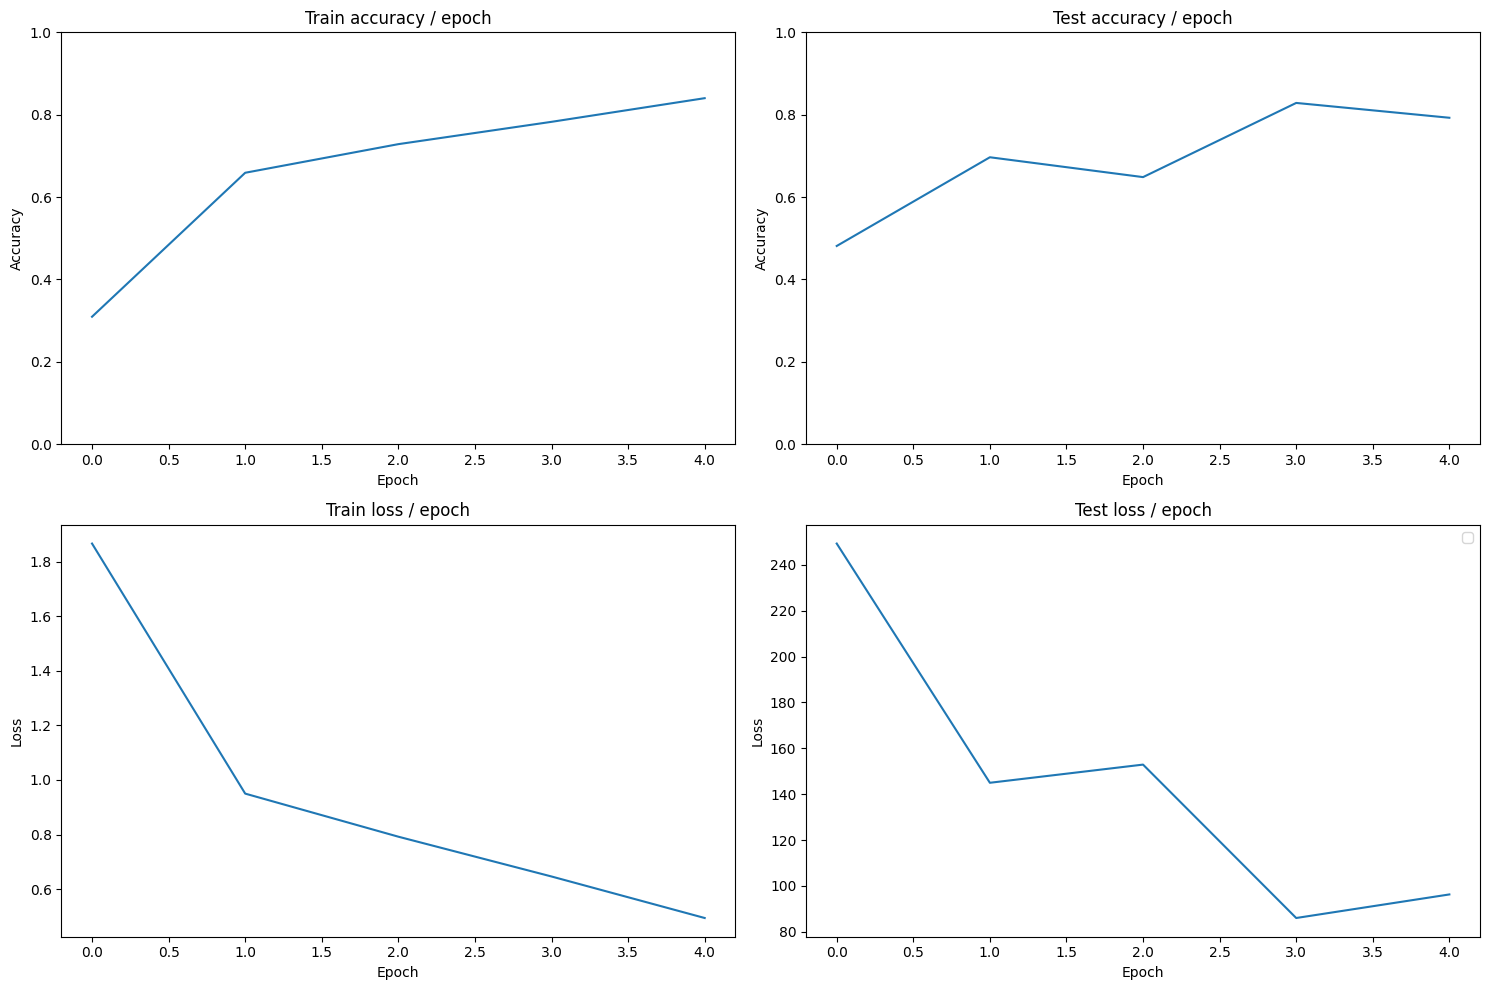

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

ax[0].plot(stats_pretrained[0])
ax[1].plot(stats_pretrained[1])
ax[2].plot(stats_pretrained[2])
ax[3].plot(stats_pretrained[3])

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 1])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 1])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("stats_vit_pretrained.pdf", dpi=100, bbox_inches="tight")
plt.show()

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.